<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D5_Microcircuits/student/W1D5_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D5_Microcircuits/student/W1D5_Tutorial1.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 1: Sparsity and Sparse Coding

**Week 1, Day 5: Microcircuits**

**By Neuromatch Academy**

__Content creators:__ Noga Mudrik, Xaq Pitkow

__Content reviewers:__ Yizhou Chen, RyeongKyung Yoon, Ruiyi Zhang, Lily Chamakura, Hlib Solodzhuk, Patrick Mineault

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk


___


# Tutorial Objectives

*Estimated timing of tutorial: 1 hour 20 minutes*

In this tutorial, we will discuss the notion of sparsity. In particular, we will:

- Recognize various types of sparsity (population, lifetime, interaction).
- Relate sparsity to inductive bias, interpretability, and efficiency.


In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
link_id = "eckvr"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

---
# Setup



In [ ]:
# @title Install and import feedback gadget

!pip install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()


feedback_prefix = "W1D5_T1"

In [1]:
# @title Imports

#working with data
import numpy as np
import pandas as pd
from scipy.stats import kurtosis

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import matplotlib.patheffects as path_effects

#interactive display
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
from tqdm.notebook import tqdm as tqdm

#modeling
from sklearn.datasets import make_sparse_coded_signal, make_regression
from sklearn.decomposition import DictionaryLearning, PCA
from sklearn.linear_model import OrthogonalMatchingPursuit
import tensorflow as tf

#utils
import os
import warnings
warnings.filterwarnings("ignore")

2024-08-21 17:57:11.007359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True
sns.set_context('talk')

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Plotting functions

def show_slice(slice_index):
    """
    Plot one slide of sequential data.

    Inputs:
    - slice_index (int): index of the slide to plot.
    """
    with plt.xkcd():
        plt.figure(figsize=(6, 6))
        plt.imshow(data[slice_index])
        ind = (66,133)
        plt.scatter([ind[1]], [ind[0]], facecolors='none', edgecolors='r', marker='s', s = 100, lw = 4)
        plt.axis('off')
        plt.show()

def remove_edges(ax, include_ticks = True, top = False, right = False, bottom = True, left = True):
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['bottom'].set_visible(bottom)
    ax.spines['left'].set_visible(left)
    if not include_ticks:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

def add_labels(ax, xlabel='X', ylabel='Y', zlabel='', title='', xlim = None, ylim = None, zlim = None,xticklabels = np.array([None]),
               yticklabels = np.array([None] ), xticks = [], yticks = [], legend = [],
               ylabel_params = {'fontsize':19},zlabel_params = {'fontsize':19}, xlabel_params = {'fontsize':19},
               title_params = {'fontsize':29}, format_xticks = 0, format_yticks = 0):
  """
  This function add labels, titles, limits, etc. to figures;
  Inputs:
      ax      = the subplot to edit
      xlabel  = xlabel
      ylabel  = ylabel
      zlabel  = zlabel (if the figure is 2d please define zlabel = None)
      etc.
  """
  if xlabel != '' and xlabel != None: ax.set_xlabel(xlabel, **xlabel_params)
  if ylabel != '' and ylabel != None:ax.set_ylabel(ylabel, **ylabel_params)
  if zlabel != '' and zlabel != None:ax.set_zlabel(zlabel,**zlabel_params)
  if title != '' and title != None: ax.set_title(title, **title_params)
  if xlim != None: ax.set_xlim(xlim)
  if ylim != None: ax.set_ylim(ylim)
  if zlim != None: ax.set_zlim(zlim)

  if (np.array(xticklabels) != None).any():
      if len(xticks) == 0: xticks = np.arange(len(xticklabels))
      ax.set_xticks(xticks);
      ax.set_xticklabels(xticklabels);
  if (np.array(yticklabels) != None).any():
      if len(yticks) == 0: yticks = np.arange(len(yticklabels)) +0.5
      ax.set_yticks(yticks);
      ax.set_yticklabels(yticklabels);
  if len(legend)       > 0:  ax.legend(legend)

def plot_signal(signal, title = "Pixel's activity over time", ylabel = '$pixel_t$'):
    """
    Plot the given signal over time.

    Inputs:
    - signal (np.array): given signal.
    - title (str, default = "Pixel's activity over time"): title to give to the plot.
    - ylabel (str, default = '$pixel_t$'): y-axis label.
    """
    with plt.xkcd():
        fig, ax = plt.subplots(1,1, figsize = (8,8), sharex = True)
        ax.plot(signal, lw = 2)
        ax.set_xlim(left = 0)
        ax.set_ylim(bottom = 0)
        add_labels(ax, xlabel = 'Time (Frames)',ylabel = ylabel, title = title)
        remove_edges(ax)
        plt.show()

def plot_relu_signal(signal, theta = 0):
    """
    Plot the given signal over time and its thresholded value with the given theta.

    Inputs:
    - signal (np.array): given signal.
    - theta (float, default = 0): threshold parameter.
    """
    with plt.xkcd():
        fig, ax = plt.subplots(1,1, figsize = (8,8), sharex = True)
        thres_x = ReLU(signal, theta)
        ax.plot(signal, lw = 2)
        ax.plot(thres_x, lw = 2)
        ax.set_xlim(left = 0)
        ax.legend(['Signal', '$ReLU_{%d}$(signal)'%theta], ncol = 2)
        add_labels(ax, xlabel = 'Time', ylabel = 'Signal')
        remove_edges(ax)
        plt.show()

def plot_relu_histogram(signal, theta = 0):
    """
    Plot histogram of the values in the signal before and after applying ReLU operation with the given threshold.

    Inputs:
    - signal (np.array): given signal.
    - theta (float, default = 0): threshold parameter.
    """
    with plt.xkcd():
        fig, axs = plt.subplots(1,2,figsize = (15,10), sharex = True, sharey = True)
        thres_x = ReLU(signal, theta)
        axs[0].hist(sig, bins = 100)
        axs[1].hist(thres_x, bins = 100)
        [remove_edges(ax) for ax in axs]
        [add_labels(ax, ylabel = 'Count', xlabel = 'Value') for ax in axs]
        [ax.set_title(title) for title, ax in zip(['Before Thresholding', 'After Thresholding'], axs)]
    plt.show()

def plot_relu_signals(signal, theta_values):
    """
    Plot the given signal over time and its thresholded value with the given theta values.

    Inputs:
    - signal (np.array): given signal.
    - theta_values (np.array): threshold parameter.
    """
    #define colormap
    with plt.xkcd():
        cmap_name = 'viridis'
        samples = np.linspace(0, 1, theta_values.shape[0])
        colors = plt.colormaps[cmap_name](samples)

        fig, ax = plt.subplots(1,1, figsize = (8,8), sharex = True)
        for counter, theta in enumerate(theta_values):
          ax.plot(ReLU(signal, theta), label = '$\\theta = %d$'%theta, color = colors[counter])
        ax.set_xlim(left = 0)
        ax.legend(ncol = 5)
        add_labels(ax, xlabel = 'Time', ylabel = '$ReLU_{\\theta}$(Signal)')
        remove_edges(ax)

def plot_images(images):
    """
    Plot given images.

    Inputs:
    - images (list): list of 2D np.arrays which represent images.
    """
    with plt.xkcd():
        fig, ax = plt.subplots(1, len(images), figsize = (15,8))
        if len(images) == 1:
            ax.imshow(images[0])
        else:
            for index, image in enumerate(images):
                ax[index].imshow(image)
    plt.show()

def plot_labeled_kurtosis(frame, frame_HT, labels = ['Frame', 'HT(frame)']):
    """
    Plot kurtosis value for the frame before and after applying hard threshold operation.

    Inputs:
    - frame (np.array): given image.
    - frame_HT (np.array): thresholded version of the given image.
    - labels (list): list of labels to apply for the igven data.
    """
    with plt.xkcd():
        fig, ax = plt.subplots()
        pd.DataFrame([kurtosis(frame.flatten()), kurtosis(frame_HT.flatten())],index = labels, columns = ['kurtosis']).plot.bar(ax = ax, alpha = 0.5, color = 'purple')
        remove_edges(ax)
    plt.show()

def plot_temporal_difference_histogram(signal, temporal_diff):
    """
    Plot histogram for the values of the given signal as well as for its temporal differenced version.

    Inputs:
    - signal (np.array): given signal.
    - temporal_diff (np.array): temporal differenced version of the signal.
    """
    with plt.xkcd():
        fig, axs = plt.subplots(1,2,figsize = (10,5), sharex = True, sharey = True)
        axs[0].hist(signal, bins = 100);
        axs[1].hist(temporal_diff, bins = 100);
        [remove_edges(ax) for ax in axs]
        [add_labels(ax, ylabel = 'Count', xlabel = 'Value') for ax in axs]
        [ax.set_title(title) for title, ax in zip(['Pixel \n Before Diff.', 'Frame \n After Diff.'], axs)]
        for line in axs[0].get_children():
            line.set_path_effects([path_effects.Normal()])
        for line in axs[1].get_children():
            line.set_path_effects([path_effects.Normal()])
        plt.show()

def plot_temp_diff_histogram(signal, taus, taus_list):
    """
    Plot the histogram for the given signal over time and its temporal differenced versions for different values of lag \tau.

    Inputs:
    - signal (np.array): given signal.
    - taus (np.array): array of tau values (lags).
    - taus_list (list): temporal differenced versions of the given signal.
    """
    #define colormap
    cmap_name = 'cool'
    samples = np.linspace(0, 1, taus.shape[0])
    colors = plt.colormaps[cmap_name](samples)

    with plt.xkcd():

        # histograms
        bin_edges = np.arange(0, 256, 5)  # Define bin edges from 0 to 255 with a step of 5

        # Compute histogram values using custom bin edges
        hist = [np.histogram(tau_list, bins=bin_edges)[0] for tau, tau_list in zip(taus, taus_list)]


        fig, ax = plt.subplots(figsize = (20,5))
        [ax.plot(bin_edges[:-1]*0.5 + bin_edges[1:]*0.5, np.vstack(hist)[j], marker = 'o', color = colors[j], label = '$\\tau = %d$'%taus[j]) for j in range(len(taus))]
        ax.legend(ncol = 2)
        remove_edges(ax)
        ax.set_xlim(left = 0, right = 100)
        add_labels(ax, xlabel = 'Value', ylabel = 'Count')
    plt.show()

def plot_temp_diff_separate_histograms(signal, lags, lags_list, tau = True):
    """
    Plot the histogram for the given signal over time and its temporal differenced versions for different values of lag \tau or windows.

    Inputs:
    - signal (np.array): given signal.
    - lags (np.array): array of lags (taus or windows).
    - lags_list (list): temporal differenced versions of the given signal.
    - tau (bool, default = True): which regime to use (tau or window).
    """
    with plt.xkcd():
        cmap_name = 'cool'
        samples = np.linspace(0, 1, lags.shape[0])
        colors = plt.colormaps[cmap_name](samples)

        fig, axs = plt.subplots(2, int(0.5*(2+lags.shape[0])),figsize = (15,10), sharex = True, sharey = False)
        axs = axs.flatten()
        axs[0].hist(signal, bins = 100, color = 'black');

        if tau:
            # histograms
            bin_edges = np.arange(0, 256, 5)  # Define bin edges from 0 to 255 with a step of 5

            # Compute histogram values using custom bin edges
            hist = [np.histogram(lag_list, bins=bin_edges)[0] for lag, lag_list in zip(lags, lags_list)]

            [axs[j+1].bar(bin_edges[:-1]*0.5 + bin_edges[1:]*0.5, np.abs( np.vstack(hist)[j]), color = colors[j]) for j in range(len(lags))]

        else:
            [axs[j+1].hist(np.abs(signal - diff_box_values_i), bins = 100, color = colors[j]) for j, diff_box_values_i in enumerate(lags_list)]

        [remove_edges(ax) for ax in axs]
        [add_labels(ax, ylabel = 'Count', xlabel = 'Value') for ax in axs]
        axs[0].set_title('Pixel \n Before Diff.');
        if tau:
            [ax.set_title( '$\\tau =$ %.2f'%lags[j]) for  j, ax in enumerate(axs[1:]) if j < lags.shape[0]]
        else:
            [ax.set_title( 'Window %d'%lags[j]) for  j, ax in enumerate(axs[1:]) if j < lags.shape[0]]

        for ax in axs:
            for line in ax.get_children():
                line.set_path_effects([path_effects.Normal()])
            for line in ax.get_children():
                line.set_path_effects([path_effects.Normal()])
    plt.show()

def plot_temp_diff_kurtosis(signal, lags, lags_list, tau = True):
    """
    Plot the kurtosis for the given signal over time and its temporal differenced versions for different values of lag \tau or windows.

    Inputs:
    - signal (np.array): given signal.
    - lags (np.array): array of lags (taus or windows).
    - lags_list (list): temporal differenced versions of the given signal.
    - tau (bool, default = True): which regime to use (tau or window).
    """
    with plt.xkcd():
        if tau:
            fig, ax = plt.subplots(figsize = (10,3))
            tauskur = [kurtosis(tau_i) for tau_i in lags_list]
            pd.DataFrame([kurtosis(signal)] + tauskur, index = ['Signal']+ ['$\\tau = {%d}$'%tau for tau in lags], columns = ['kurtosis']).plot.barh(ax = ax, alpha = 0.5, color = 'purple')
            remove_edges(ax)
        else:
            fig, ax = plt.subplots(figsize = (7,7))
            tauskur = [kurtosis(np.abs(signal - diff_box_values_i)) for diff_box_values_i in lags_list]
            pd.DataFrame([kurtosis(signal)] + tauskur, index = ['Signal']+ ['$window = {%d}$'%tau for tau in lags], columns = ['kurtosis']).plot.bar(ax = ax, alpha = 0.5, color = 'purple')
            remove_edges(ax)

def plot_diff_box(signal, filter, diff_box_signal):
    """
    Plot signal, the window function and the resulted convolution.

    Inputs:
    - signal (np.array): the given signal.
    - filter (int): size of the window function.
    - diff_box_signal (np.array): the resulted signal.
    """

    with plt.xkcd():
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
            ax[0].plot(signal)
            ax[0].set_title('Signal')
            ax[1].plot(filter)
            ax[1].set_title('Filter Function')
            ax[2].plot(diff_box_signal)
            ax[2].set_title('diff_box Signal')
            plt.subplots_adjust(wspace=0.3)
            [ax_i.set_xlabel('Time') for ax_i in ax]
    plt.show()

def plot_diff_with_diff_box(signal, windows, diff_box_values):
    """
    Plot difference between given signal and diff_box ones for different windows.

    Inputs:
    - signal (np.array): given signal.
    - windows (np.array): list of window sizes.
    - diff_box_values (list): list for diff_box versions of the signal.
    """
    with plt.xkcd():
        cmap_name = 'cool'
        samples = np.linspace(0, 1, windows.shape[0])
        colors = plt.colormaps[cmap_name](samples)

        fig, ax = plt.subplots(figsize = (15,10))
        ax.plot(signal, label = "Signal")
        [ax.plot(signal - diff_box_values_i, color = colors[j], label = 'window = %d'%windows[j]) for j, diff_box_values_i in enumerate(diff_box_values)]
        ax.legend(ncol = 4)
        remove_edges(ax)
        ax.set_xlim(left = 0, right = 100)
        add_labels(ax, xlabel = 'Time (frame)', ylabel = '$\Delta(pixel)$')
    plt.show()

def plot_spatial_diff(frame, diff_x,  diff_y):
    """
    Plot spatial differentiation of the given image with lag one.

    Inputs:
    - frame (np.array): given 2D signal (image).
    - diff_x (np.array): spatial difference along x-axis.
    - diff_y (np.array): spatial difference along y-axis.
    """

    with plt.xkcd():
        fig, axs = plt.subplots(1,3, figsize = (15,10))
        diff_x_norm = (diff_x - np.percentile(diff_x, 10))/(np.percentile(diff_x, 90) - np.percentile(diff_x, 10))
        diff_x_norm = diff_x_norm*255
        diff_x_norm[diff_x_norm > 255] = 255
        diff_x_norm[diff_x_norm < 0] = 0
        axs[0].imshow(diff_x_norm.astype(np.uint8))
        diff_y_norm = (diff_y - np.percentile(diff_y, 10))/(np.percentile(diff_y, 90) - np.percentile(diff_y, 10))
        diff_y_norm = diff_y_norm*255
        diff_y_norm[diff_y_norm > 255] = 255
        diff_y_norm[diff_y_norm < 0] = 0
        axs[1].imshow(diff_y_norm.astype(np.uint8))
        axs[2].imshow(frame)
        [ax.set_xticks([]) for ax in axs]
        [ax.set_yticks([]) for ax in axs]
        [ax.set_title(title, fontsize = 40) for title, ax in zip(['$\Delta x$', '$\Delta y$', 'Original'], axs)];

def plot_spatial_diff_histogram(taus, taus_list_x, taus_list_y):
    """
    Plot histograms for each of the spatial differenced version of the signal.
    """

    with plt.xkcd():
        cmap_name = 'cool'
        samples = np.linspace(0, 1, taus.shape[0])
        colors = plt.colormaps[cmap_name](samples)

        bin_edges = np.arange(0, 256, 5)  # Define bin edges from 0 to 255 with a step of 5

        hist_x = [np.histogram(tau_list.flatten() ,  bins=bin_edges)[0] for tau, tau_list in zip(taus, taus_list_x )]
        hist_y = [np.histogram(tau_list.flatten(),  bins=bin_edges)[0] for tau, tau_list in zip(taus, taus_list_y)]

        fig, axs = plt.subplots(2,1,figsize = (15,9))
        ax = axs[0]
        [ax.plot(bin_edges[:-1]*0.5 + bin_edges[1:]*0.5, np.vstack(hist_x)[j], marker = 'o', color = colors[j], label = '$\\tau = %d$'%taus[j]) for j in range(len(taus))]
        ax.set_yscale('log')
        ax.legend(ncol = 2)
        remove_edges(ax)
        ax.set_xlim(left = 0, right = 100)
        add_labels(ax, xlabel = '$\\tau_x$', ylabel = 'Count', title = 'Diff. in $x$')

        ax = axs[1]
        [ax.plot(bin_edges[:-1]*0.5 + bin_edges[1:]*0.5, np.vstack(hist_y)[j], marker = 'o', color = colors[j], label = '$\\tau = %d$'%taus[j]) for j in range(len(taus))]
        ax.set_yscale('log')
        ax.legend(ncol = 2)
        remove_edges(ax)
        ax.set_xlim(left = 0, right = 100)
        add_labels(ax, xlabel = '$\\tau_y$', ylabel = 'Count', title = 'Diff. in $y$')

        fig.tight_layout()
    plt.show()

def plot_spatial_kurtosis(frame, diff_x, diff_y):
    """
    Plot kurtosis for the signal and its spatial differenced version.
    """
    with plt.xkcd():
        fig, ax = plt.subplots()
        pd.DataFrame([kurtosis(frame.flatten()), kurtosis(diff_x.flatten()), kurtosis(diff_y.flatten())],index = ['Signal', 'Diff $x$', 'Diff $y$'], columns = ['kurtosis']).plot.barh(ax = ax, alpha = 0.5, color = 'purple')
        remove_edges(ax)
    plt.show()

def plot_spatial_histogram(frame, diff_x, diff_y):
    """
    Plot histogram for values in frame and differenced versions.
    """
    with plt.xkcd():
        fig, axs = plt.subplots(1,3,figsize = (15,10), sharex = True, sharey = True)
        axs[0].hist(np.abs(frame.flatten()), bins = 100);
        axs[1].hist(np.abs(diff_x.flatten()), bins = 100);
        axs[2].hist(np.abs(diff_y.flatten()), bins = 100);
        [remove_edges(ax) for ax in axs]
        [add_labels(ax, ylabel = 'Count', xlabel = 'Value') for ax in axs]
        [ax.set_title(title) for title, ax in zip(['Frame \n Before Diff.', 'Frame \n After Diff. x', 'Frame \n After Diff. y'], axs)]

def visualize_images_diff_box(frame, diff_box_values_x, diff_box_values_y, num_winds):
    """
    Plot images with diff_box difference method.
    """
    with plt.xkcd():
        cmap_name = 'cool'
        samples = np.linspace(0, 1, num_winds)
        colors = plt.colormaps[cmap_name](samples)
        fig, axs = plt.subplots( 2, int(0.5*(2+ len(diff_box_values_x))),  figsize = (15,15))
        axs = axs.flatten()
        axs[0].imshow(frame)
        [axs[j+1].imshow(normalize(frame - diff_box_values_i)) for j, diff_box_values_i in enumerate(diff_box_values_x)]
        remove_edges(axs[-1], left = False, bottom = False, include_ticks=  False)
        fig.suptitle('x diff')

        fig, axs = plt.subplots( 2, int(0.5*(2+ len(diff_box_values_x))),  figsize = (15,15))
        axs = axs.flatten()
        axs[0].imshow(frame)
        [axs[j+1].imshow(normalize(frame.T - diff_box_values_i).T) for j, diff_box_values_i in enumerate(diff_box_values_y)]
        remove_edges(axs[-1], left = False, bottom = False, include_ticks=  False)
        fig.suptitle('y diff')

def create_legend(dict_legend, size = 30, save_formats = ['.png','.svg'],
                      save_addi = 'legend' , dict_legend_marker = {},
                      marker = '.', style = 'plot', s = 500, plot_params = {'lw':5},
                      params_leg = {}):
    fig, ax = plt.subplots(figsize = (5,5))
    if style == 'plot':
        [ax.plot([],[],
                     c = dict_legend[area], label = area, marker = dict_legend_marker.get(area), **plot_params) for area in dict_legend]
    else:
        if len(dict_legend_marker) == 0:
            [ax.scatter([],[], s=s,c = dict_legend.get(area), label = area, marker = marker, **plot_params) for area in dict_legend]
        else:
            [ax.scatter([],[], s=s,c = dict_legend[area], label = area, marker = dict_legend_marker.get(area), **plot_params) for area in dict_legend]
    ax.legend(prop = {'size':size},**params_leg)
    remove_edges(ax, left = False, bottom = False, include_ticks = False)

def ReLU_implemented(x, theta = 0):
    """
    Calculates ReLU function for the given level of theta (implemented version of first exercise).

    Inputs:
    - x (np.ndarray): input data.
    - theta (float, default = 0): threshold parameter.

    Outputs:
    - thres_x (np.ndarray): filtered values.
    """

    thres_x = np.maximum(x - theta, 0)

    return thres_x

def plot_kurtosis(theta_value):
    """
    Plot kurtosis value for the signal before and after applying ReLU operation with the given threshold value.

    Inputs:
    - theta_value (int):  threshold parameter value.
    """
    with plt.xkcd():
        fig, ax = plt.subplots()
        relu = kurtosis(ReLU_implemented(sig, theta_value))
        pd.DataFrame([kurtosis(sig)] + [relu], index = ['Signal']+ ['$ReLU_{%d}$(signal)'%theta_value], columns = ['kurtosis']).plot.bar(ax = ax, alpha = 0.5, color = 'purple')
        remove_edges(ax)
        plt.show()

In [4]:
# @title Helper functions

def normalize(mat):
    """
    Normalize input matrix from 0 to 255 values (in RGB range).

    Inputs:
    - mat (np.ndarray): data to normalize.

    Outpus:
    - (np.ndarray): normalized data.
    """
    mat_norm = (mat - np.percentile(mat, 10))/(np.percentile(mat, 90) - np.percentile(mat, 10))
    mat_norm = mat_norm*255
    mat_norm[mat_norm > 255] = 255
    mat_norm[mat_norm < 0] = 0
    return mat_norm

def lists2list(xss):
    """
    Flatten a list of lists into a single list.

    Inputs:
    - xss (list): list of lists. The list of lists to be flattened.

    Outputs:
    - (list): The flattened list.
    """
    return [x for xs in xss for x in xs]

# exercise solutions for correct plots

def ReLU(x, theta = 0):
    """
    Calculates ReLU function for the given level of theta.

    Inputs:
    - x (np.ndarray): input data.
    - theta (float, default = 0): threshold parameter.

    Outputs:
    - thres_x (np.ndarray): filtered values.
    """

    thres_x = np.maximum(x - theta, 0)

    return thres_x

sig = np.load('sig.npy')
temporal_diff = np.abs(np.diff(sig))

num_taus = 10
taus = np.linspace(1, 91, num_taus).astype(int)
taus_list = [np.abs(sig[tau:] - sig[:-tau]) for tau in taus]

T_ar = np.arange(len(sig))

freqs = np.linspace(0.001, 1, 100)
set_sigs = [np.sin(T_ar*f) for f in freqs]

reg = OrthogonalMatchingPursuit(fit_intercept = True, n_nonzero_coefs = 10).fit(np.vstack(set_sigs).T, sig)

In [5]:
# @title Data retrieval

import os
import requests
import hashlib

# Variables for file and download URL
fnames = ["frame1.npy", "sig.npy", "reweight_digits.npy", "model.npy", "video_array.npy"] # The names of the files to be downloaded
urls = ["https://osf.io/n652y/download", "https://osf.io/c9qxk/download", "https://osf.io/ry5am/download", "https://osf.io/uebw5/download", "https://osf.io/t9g2m/download"] # URLs from where the files will be downloaded
expected_md5s = ["6ce619172367742dd148cc5830df908c", "f3618e05e39f6df5997f78ea668f2568", "1f2f3a5d08e13ed2ec3222dca1e85b60", "ae20e6321836783777c132149493ec70", "bbd1d73eeb7f5c81768771ceb85c849e"] # MD5 hashes for verifying files integrity

for fname, url, expected_md5 in zip(fnames, urls, expected_md5s):
    if not os.path.isfile(fname):
        try:
            # Attempt to download the file
            r = requests.get(url) # Make a GET request to the specified URL
        except requests.ConnectionError:
            # Handle connection errors during the download
            print("!!! Failed to download data !!!")
        else:
            # No connection errors, proceed to check the response
            if r.status_code != requests.codes.ok:
                # Check if the HTTP response status code indicates a successful download
                print("!!! Failed to download data !!!")
            elif hashlib.md5(r.content).hexdigest() != expected_md5:
                # Verify the integrity of the downloaded file using MD5 checksum
                print("!!! Data download appears corrupted !!!")
            else:
                # If download is successful and data is not corrupted, save the file
                with open(fname, "wb") as fid:
                    fid.write(r.content) # Write the downloaded content to a file

---
# Section 1: Introduction to sparsity

In [ ]:
# @title Video 1: Introduction to sparsity

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'Qr9wnQ4iqvQ'), ('Bilibili', 'BV1Vb421n7W3')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_introduction_to_sparsity")

### Sparsity in Neuroscience and Artificial Intelligence

**Sparse** means rare or thinly spread out.

Neuroscience and AI both use notions of sparsity to describe efficient representations of the world. The concept of sparsity is usually applied to two things: **sparse activity** and **sparse connections**.

**Sparse activity** means that only a small number of neurons or units are active at any given time. Computationally, this helps reduce energy consumption and focuses computational efforts on the most salient features of the data. In modeling the world, it reflects how natural scenes usually contain a small number out of all possible objects or features.

**Sparse connections** refers to the selective interaction between neurons or nodes, for example, through a graph that is far from fully connected. Computationally, this can focus processing power where it is most needed. In modeling the world, it reflects that many represented objects or features properties directly relate only to a few others.

In the brain, we see sparsity of both types, and researchers have made many theories about its benefits. In AI, regularization often imposes sparsity, providing a variety of performance and generalization benefits.

This tutorial will explore a few of these benefits. First, we will calculate how various simple computations affect sparsity, and then we will examine how sparsity can affect inferences.



### How can we quantify sparsity?
- **$\ell_0$ pseudo-norm** -- the count of non-zero values: $\|\mathbf{x}\|_{\ell_0}=\sum_i \mathbb{1}_{x_i\neq0}$ where $\mathbb{1}$ is an indicator function equal to 1 if and only if the argument is true. This is more difficult to work with than other proxy measures that are convex or differentiable.

- **$\ell_1$ norm** -- the sum of the absolute values: $\|\mathbf{x}\|_{\ell_1}=\sum_i |x_i|$

- **Kurtosis** -- a fourth-order measure that quantifies the "tails" of the distribution: $\kappa=\mathbb{E}_x \left(\frac{x-\mu}{\sigma}\right)^4$. Higher kurtosis indicates both longer tails and smaller values and, thus, greater sparsity.

- **Cardinality** -- in this context, refers to the number of active (non-zero) features in a model, which determines its sparsity and affects its ability to capture and express complex data patterns.

![Sparsity notion visualization.](https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D5_Microcircuits/static/sparsity.png?raw=true)

--------------------------
# Section 2: Computing and altering sparsity

*Estimated timing to here from start of tutorial: 10 minutes.*

Under what scenarios do we encounter sparsity in real life? In this first section, we will explore various contexts and methods through which natural sparsity manifests in real-world signals. We will focus on the effects of nonlinearity and temporal derivatives.

---
## Section 2.1: Sparsity via nonlinearity

In [ ]:
# @title Video 2: Natural sparsity

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', '_ZHtLgFeiD4'), ('Bilibili', 'BV19f421B77m')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_natural_sparsity")

### Coding Exercise 2.1: Sparsity as the result of thresholding

In this exercise, we will understand how a nonlinearity can increase sparsity.

For the first exercise, we will analyze a video of a bird in San Francisco to extract temporal sparsity. You can navigate through the video using the slider provided below.

Specifically, to explore temporal sparsity (i.e., sparsity across time, also called lifetime sparsity), we will focus on the activity of a particular pixel, the one marked in red, across various frames.

In [6]:
# @title Execute the cell to see the interactive widget!

data = np.load('video_array.npy')
slider = IntSlider(min=0, max=data.shape[0] - 1, step=1, value=0, description= 'Time Point')
interact(show_slice, slice_index=slider)

interactive(children=(IntSlider(value=0, description='Time Point', max=716), Output()), _dom_classes=('widget-…

<function __main__.show_slice(slice_index)>

Now, let's look at the marked pixel's activity over time and visualize it.

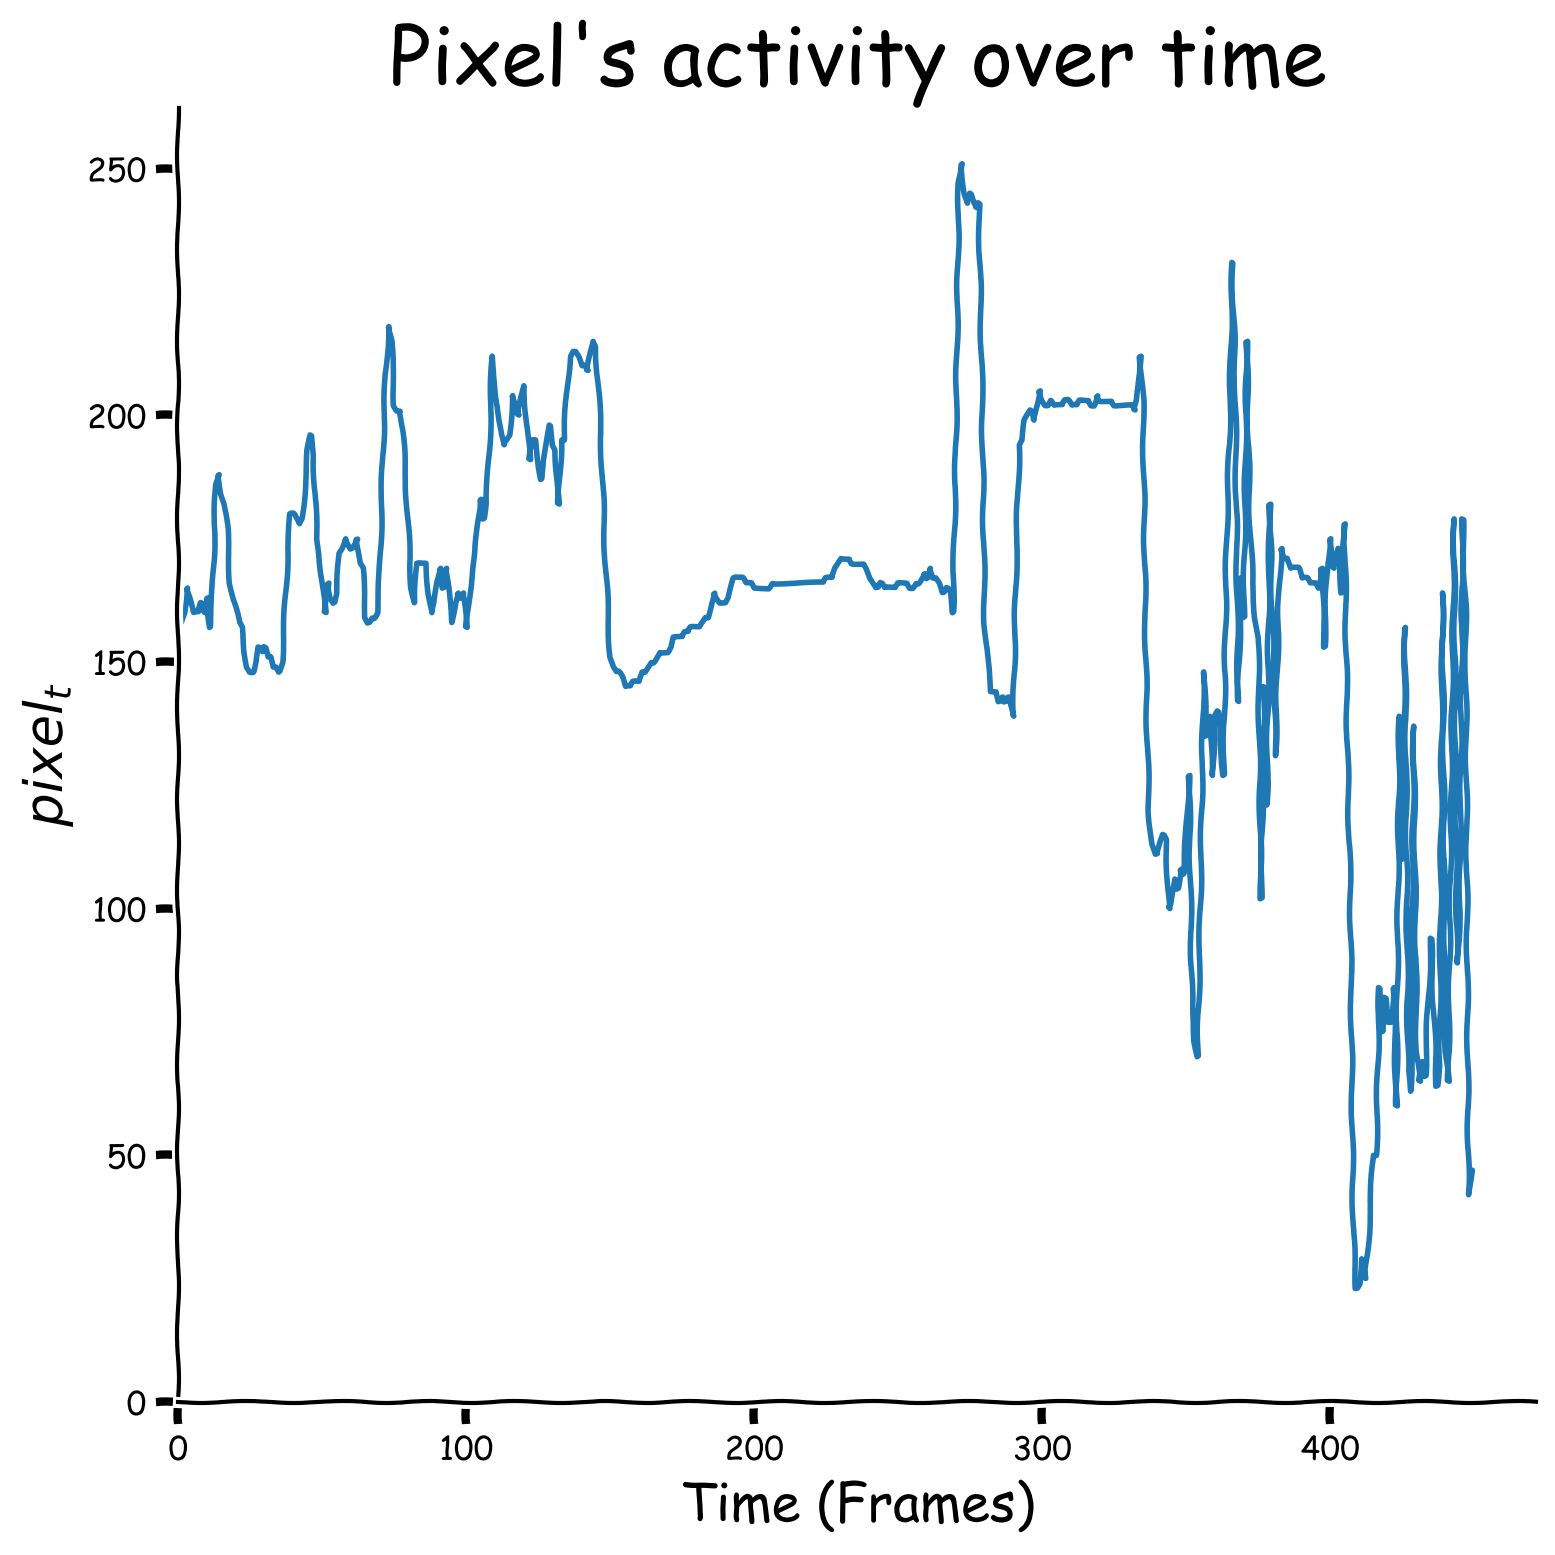

In [7]:
# @title Plot of change in pixel's value over time

sig = np.load('sig.npy')
plot_signal(sig)

Write a function called "**ReLU**" that receives 2 inputs:

- $\mathbf{x}$: a 1d numpy array of $p$ floats.

- $\theta$: a scalar threshold.

The function should return a numpy array called `thres_x` such that for each element $j$:

$$
\text{thres-x}_j =
\begin{cases}
x_j - \theta & \text{if } x_j \geq \theta \\
0 & \text{otherwise}
\end{cases}
$$



Apply the ReLU  function to the signal "**sig**" with a threshold of $\theta =  150$.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete `thres_x` array calculation as defined.")
###################################################################

def ReLU(x, theta = 0):
    """
    Calculates ReLU function for the given level of theta.

    Inputs:
    - x (np.ndarray): input data.
    - theta (float, default = 0): threshold parameter.

    Outputs:
    - thres_x (np.ndarray): filtered values.
    """

    thres_x = ...

    return thres_x

In [8]:
#to_remove solution
def ReLU(x, theta = 0):
    """
    Calculates ReLU function for the given level of theta.

    Inputs:
    - x (np.ndarray): input data.
    - theta (float, default = 0): threshold parameter.

    Outputs:
    - thres_x (np.ndarray): filtered values.
    """

    thres_x = np.maximum(x - theta, 0)

    return thres_x

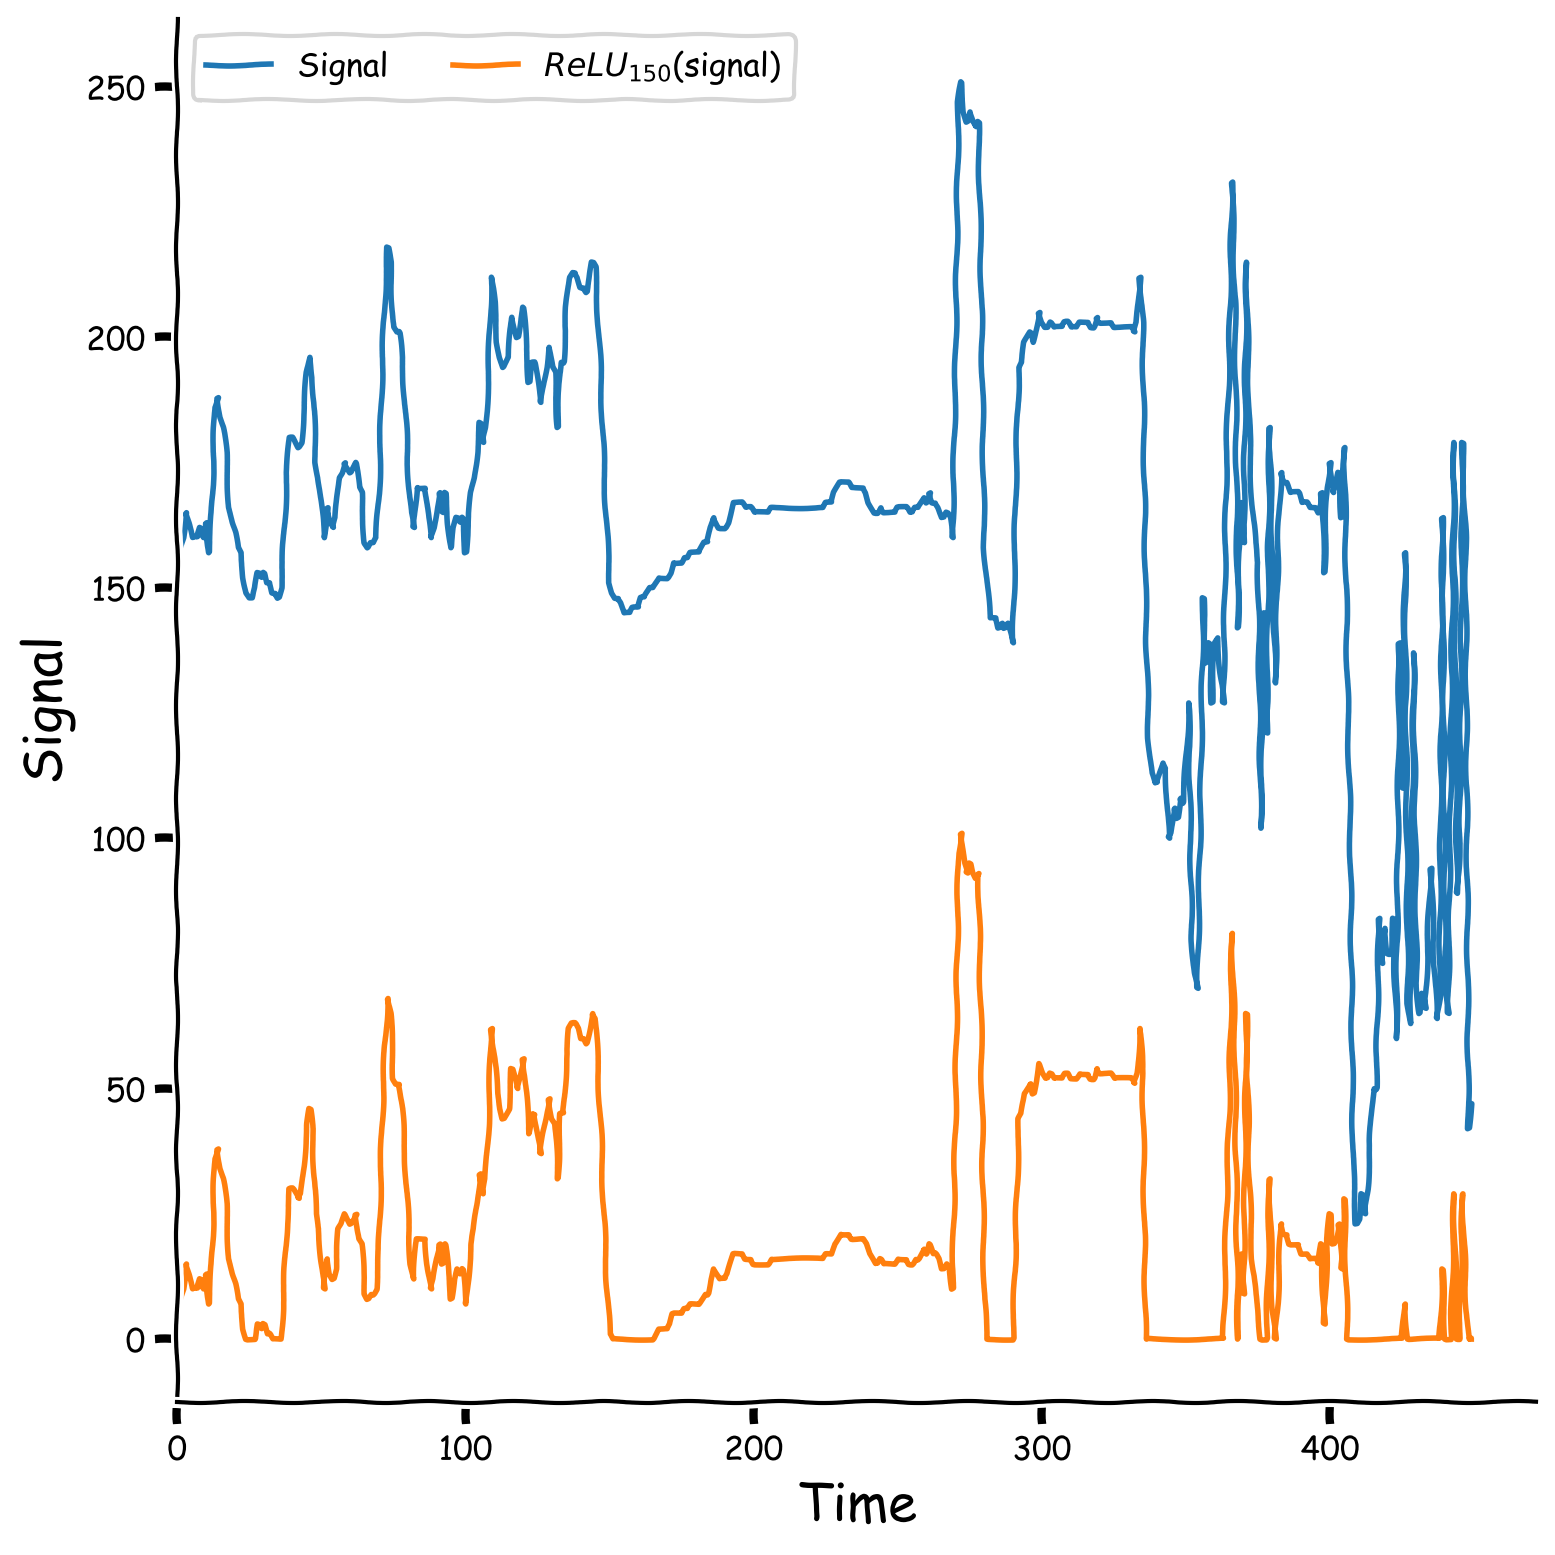

In [9]:
# @title Plot your results

plot_relu_signal(sig, theta = 150)

Let us also take a look at the aggregated plot, which takes threshold parameter values from 0 to 240 with step 20 and plots the ReLU version of the signal for each of them.

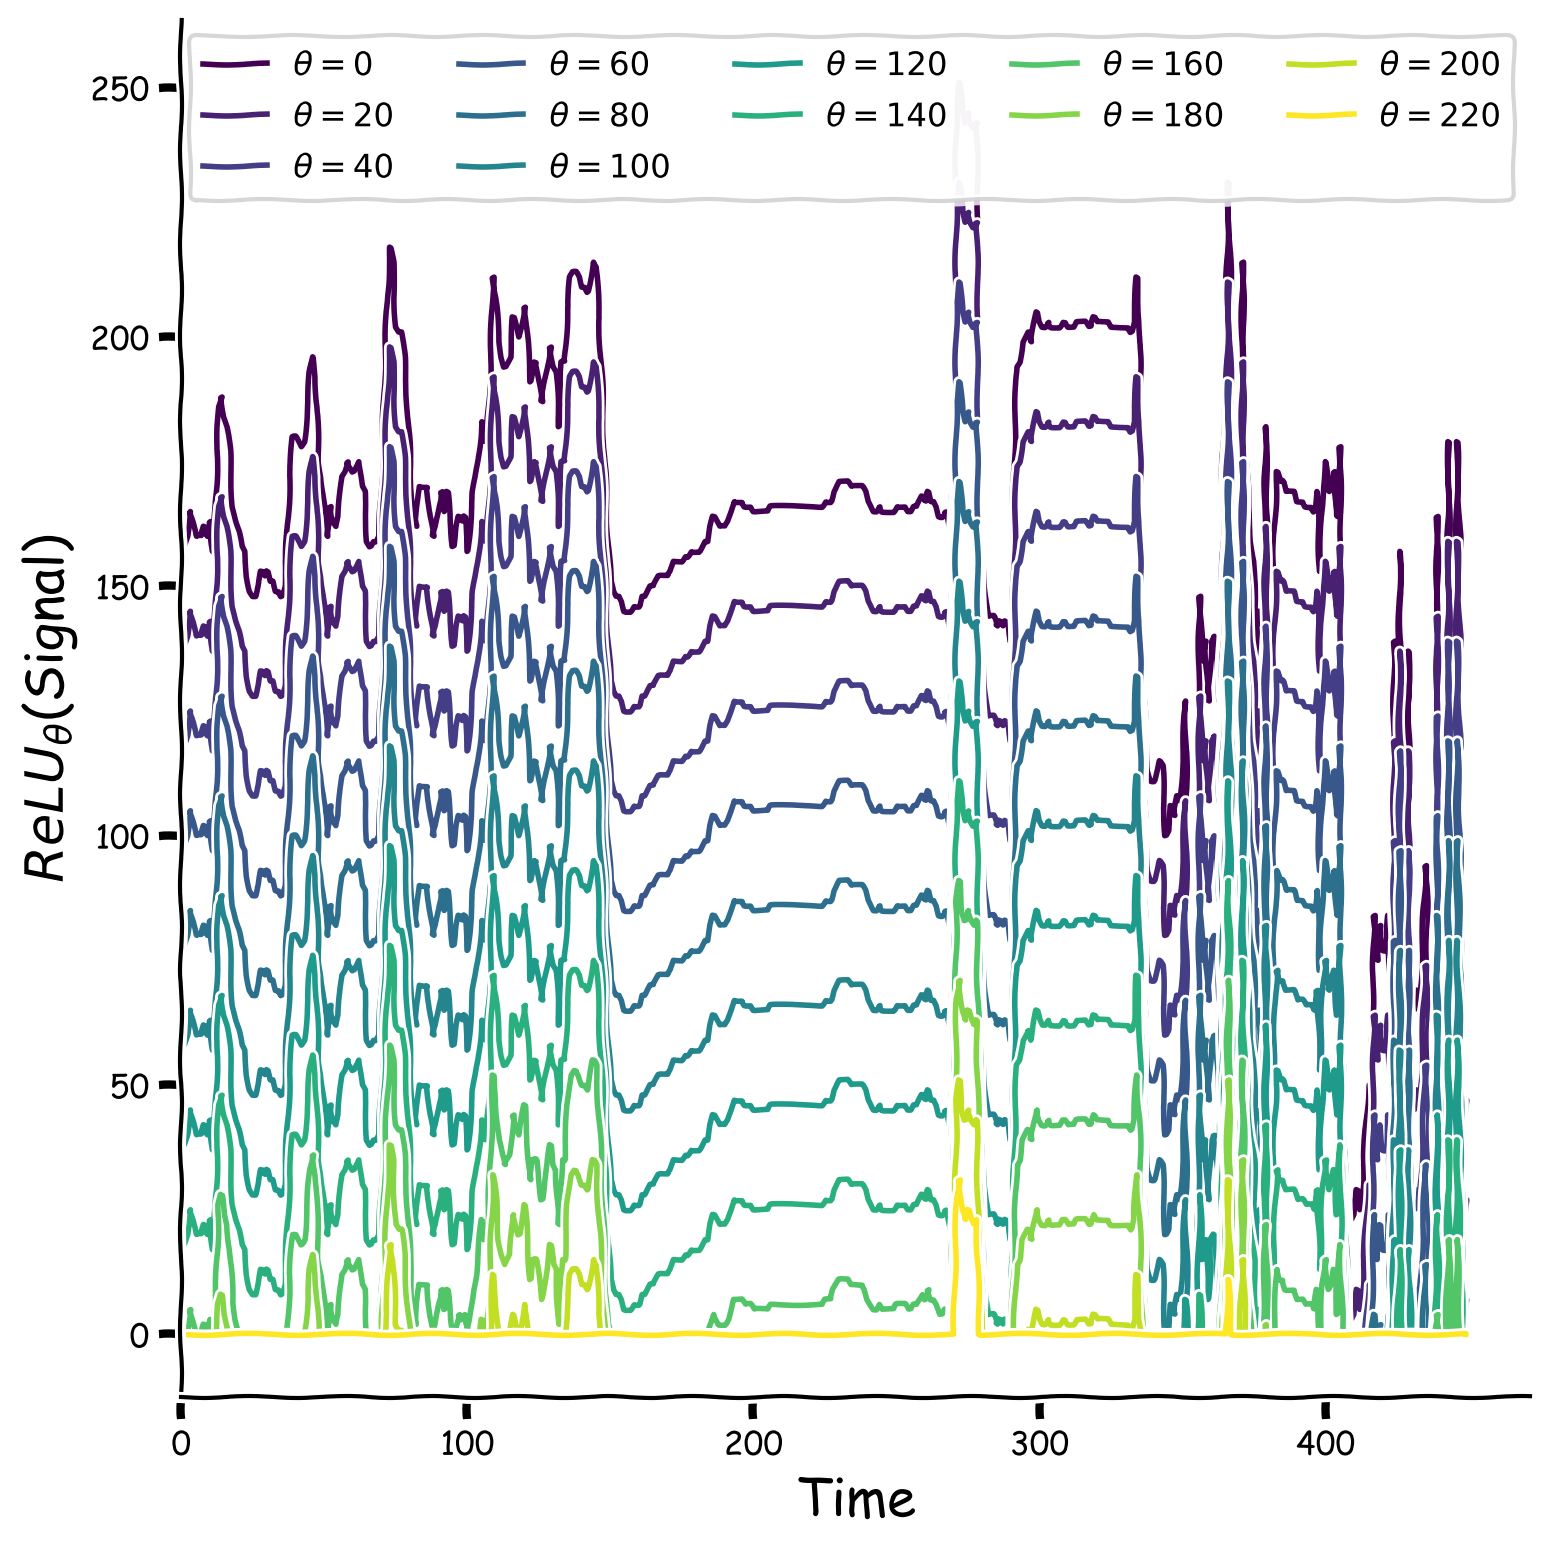

In [10]:
# @title Threshold value impact on ReLU version of the signal

theta_values = np.arange(0, 240, 20)
plot_relu_signals(sig ,theta_values)

Finally, let's calculate the kurtosis value to estimate the signal's sparsity compared to its version passed through the ReLU function.

Try to gradually increase the threshold parameter ($\theta$) from 0 to 240 in intervals of 20 and plot the result for each value. How does the threshold affect the sparsity?

In [11]:
# @title Kurtosis value comparison

slider = IntSlider(min=0, max=240, step=20, value=0, description='Threshold')
interact(plot_kurtosis, theta_value = slider)

interactive(children=(IntSlider(value=0, description='Threshold', max=240, step=20), Output()), _dom_classes=(…

<function __main__.plot_kurtosis(theta_value)>

<details>
    <summary>Kurtosis value behaviour</summary>
    You might notice that, at first, the kurtosis value decreases (around till $\theta = 140$), and then it drastically increases (reflecting the desired sparsity property). If we take a closer look at the kurtosis formula, it measures the expected value (average) of standardized data values raised to the 4th power. That being said, if the data point lies in the range of standard deviation, it doesn’t contribute to the kurtosis value almost at all (something less than 1 to the fourth degree is small), and most of the contribution is produced by extreme outliers (lying far away from the range of standard deviation). So, the main characteristic it measures is the tailedness of the data - it will be high when the power of criticality of outliers will overweight the “simple” points (as kurtosis is an average metric for all points). What happens is that with $\theta \le 120$, outliers don't perform that much to the kurtosis.
</details>


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_sparsity_as_the_result_of_thresholding")

---
## Section 2.2: Sparsity from temporal differentiation

*Estimated timing to here from start of tutorial: 20 minutes.*

In this section, you will increase temporal sparsity in a natural 1D time series by *temporal differencing*. Changes in the world are sparse and thus tend to be especially informative, so computations highlighting those changes can be beneficial.

This could be implemented by feedforward inhibition in a neural circuit.

In [ ]:
# @title Video 3: Temporal differentiation

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'VaDioX2ZOqI'), ('Bilibili', 'BV1yE421P73H')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_temporal_differentiation")

### Coding Exercise 2.2: Temporal differencing signal


Denote the pixel value at time $t$ by $pixel_t$. Mathematically, we define the (absolute) temporal differences as

$$\Delta_t = |pixel_t - pixel_{t-1}|$$

In code, define these absolute temporal differences to compute `temporal_diff` by applying `np.diff` on the signal `sig` and then applying `np.abs` to get absolute values.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete temporal differentiation.")
###################################################################
temporal_diff = ...

In [ ]:
#to_remove solution
temporal_diff = np.abs(np.diff(sig))

In [ ]:
# @title Observe the result
plot_signal(temporal_diff, title = "", ylabel = "$| pixel_t - pixel_{t-1} | $")

Let's take a look at the histogram of the temporal difference values as well as kurtosis values.

In [ ]:
# @title Histograms for the signal and its temporal differences
plot_temporal_difference_histogram(sig, temporal_diff)

In [ ]:
# @title Kurtosis values for the signal and its temporal differences
plot_labeled_kurtosis(sig, temporal_diff, labels = ['Signal', 'Temporal \n Diff.'])

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_temporal_differencing_signal")

### Coding Exercise 2.3: Changes over longer delays

What happens if we look at differences at longer delays $\tau>1$?

$$\Delta_t(\tau) = |pixel_t - pixel_{t-\tau}|$$

In this exercise, we will explore the effects of increasing $\tau$ values on the sparsity of the temporal differentiation signal.

1) Create an array of 10 different $\tau$ values: $taus = [1, 11, 21... , 91]$.

2) Create a list called **taus_list** composed of 10 arrays where each array is the temporal differentiation with a different interval $\tau$.

3) Compare the histograms of temporal differences for each different tau. Plot these histograms together, with all histograms using the same bins.

Pay attention: here, it is NOT recommended to use the built-in `np.diff` function.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete calcualtion of `taus` and `taus_list`.")
###################################################################
num_taus = 10

# create taus
taus = np.linspace(1, 91, ...).astype(int)

# create taus_list
taus_list = [np.abs(sig[...:] - sig[:-tau]) for tau in taus]

In [12]:
#to_remove solution
num_taus = 10

# create taus
taus = np.linspace(1, 91, num_taus).astype(int)

# create taus_list
taus_list = [np.abs(sig[tau:] - sig[:-tau]) for tau in taus]

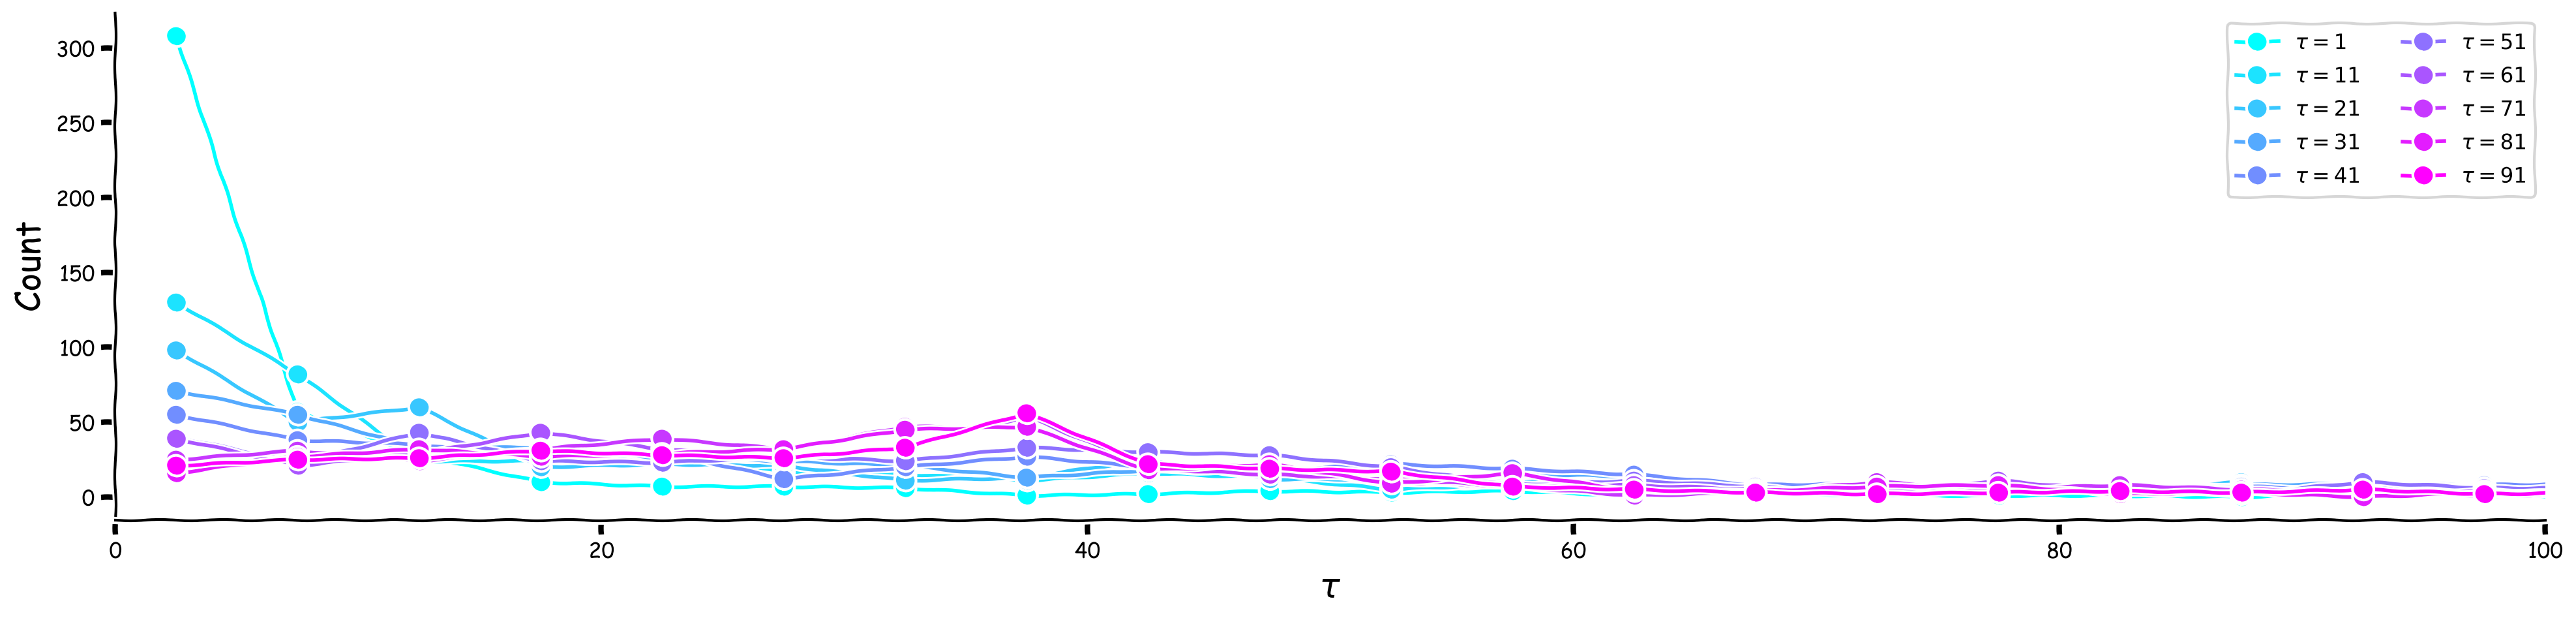

In [13]:
# @title Plot your results
plot_temp_diff_histogram(sig, taus, taus_list)

Now, let us look at the histograms for each $\tau$ separately, as well as for the kurtosis values.

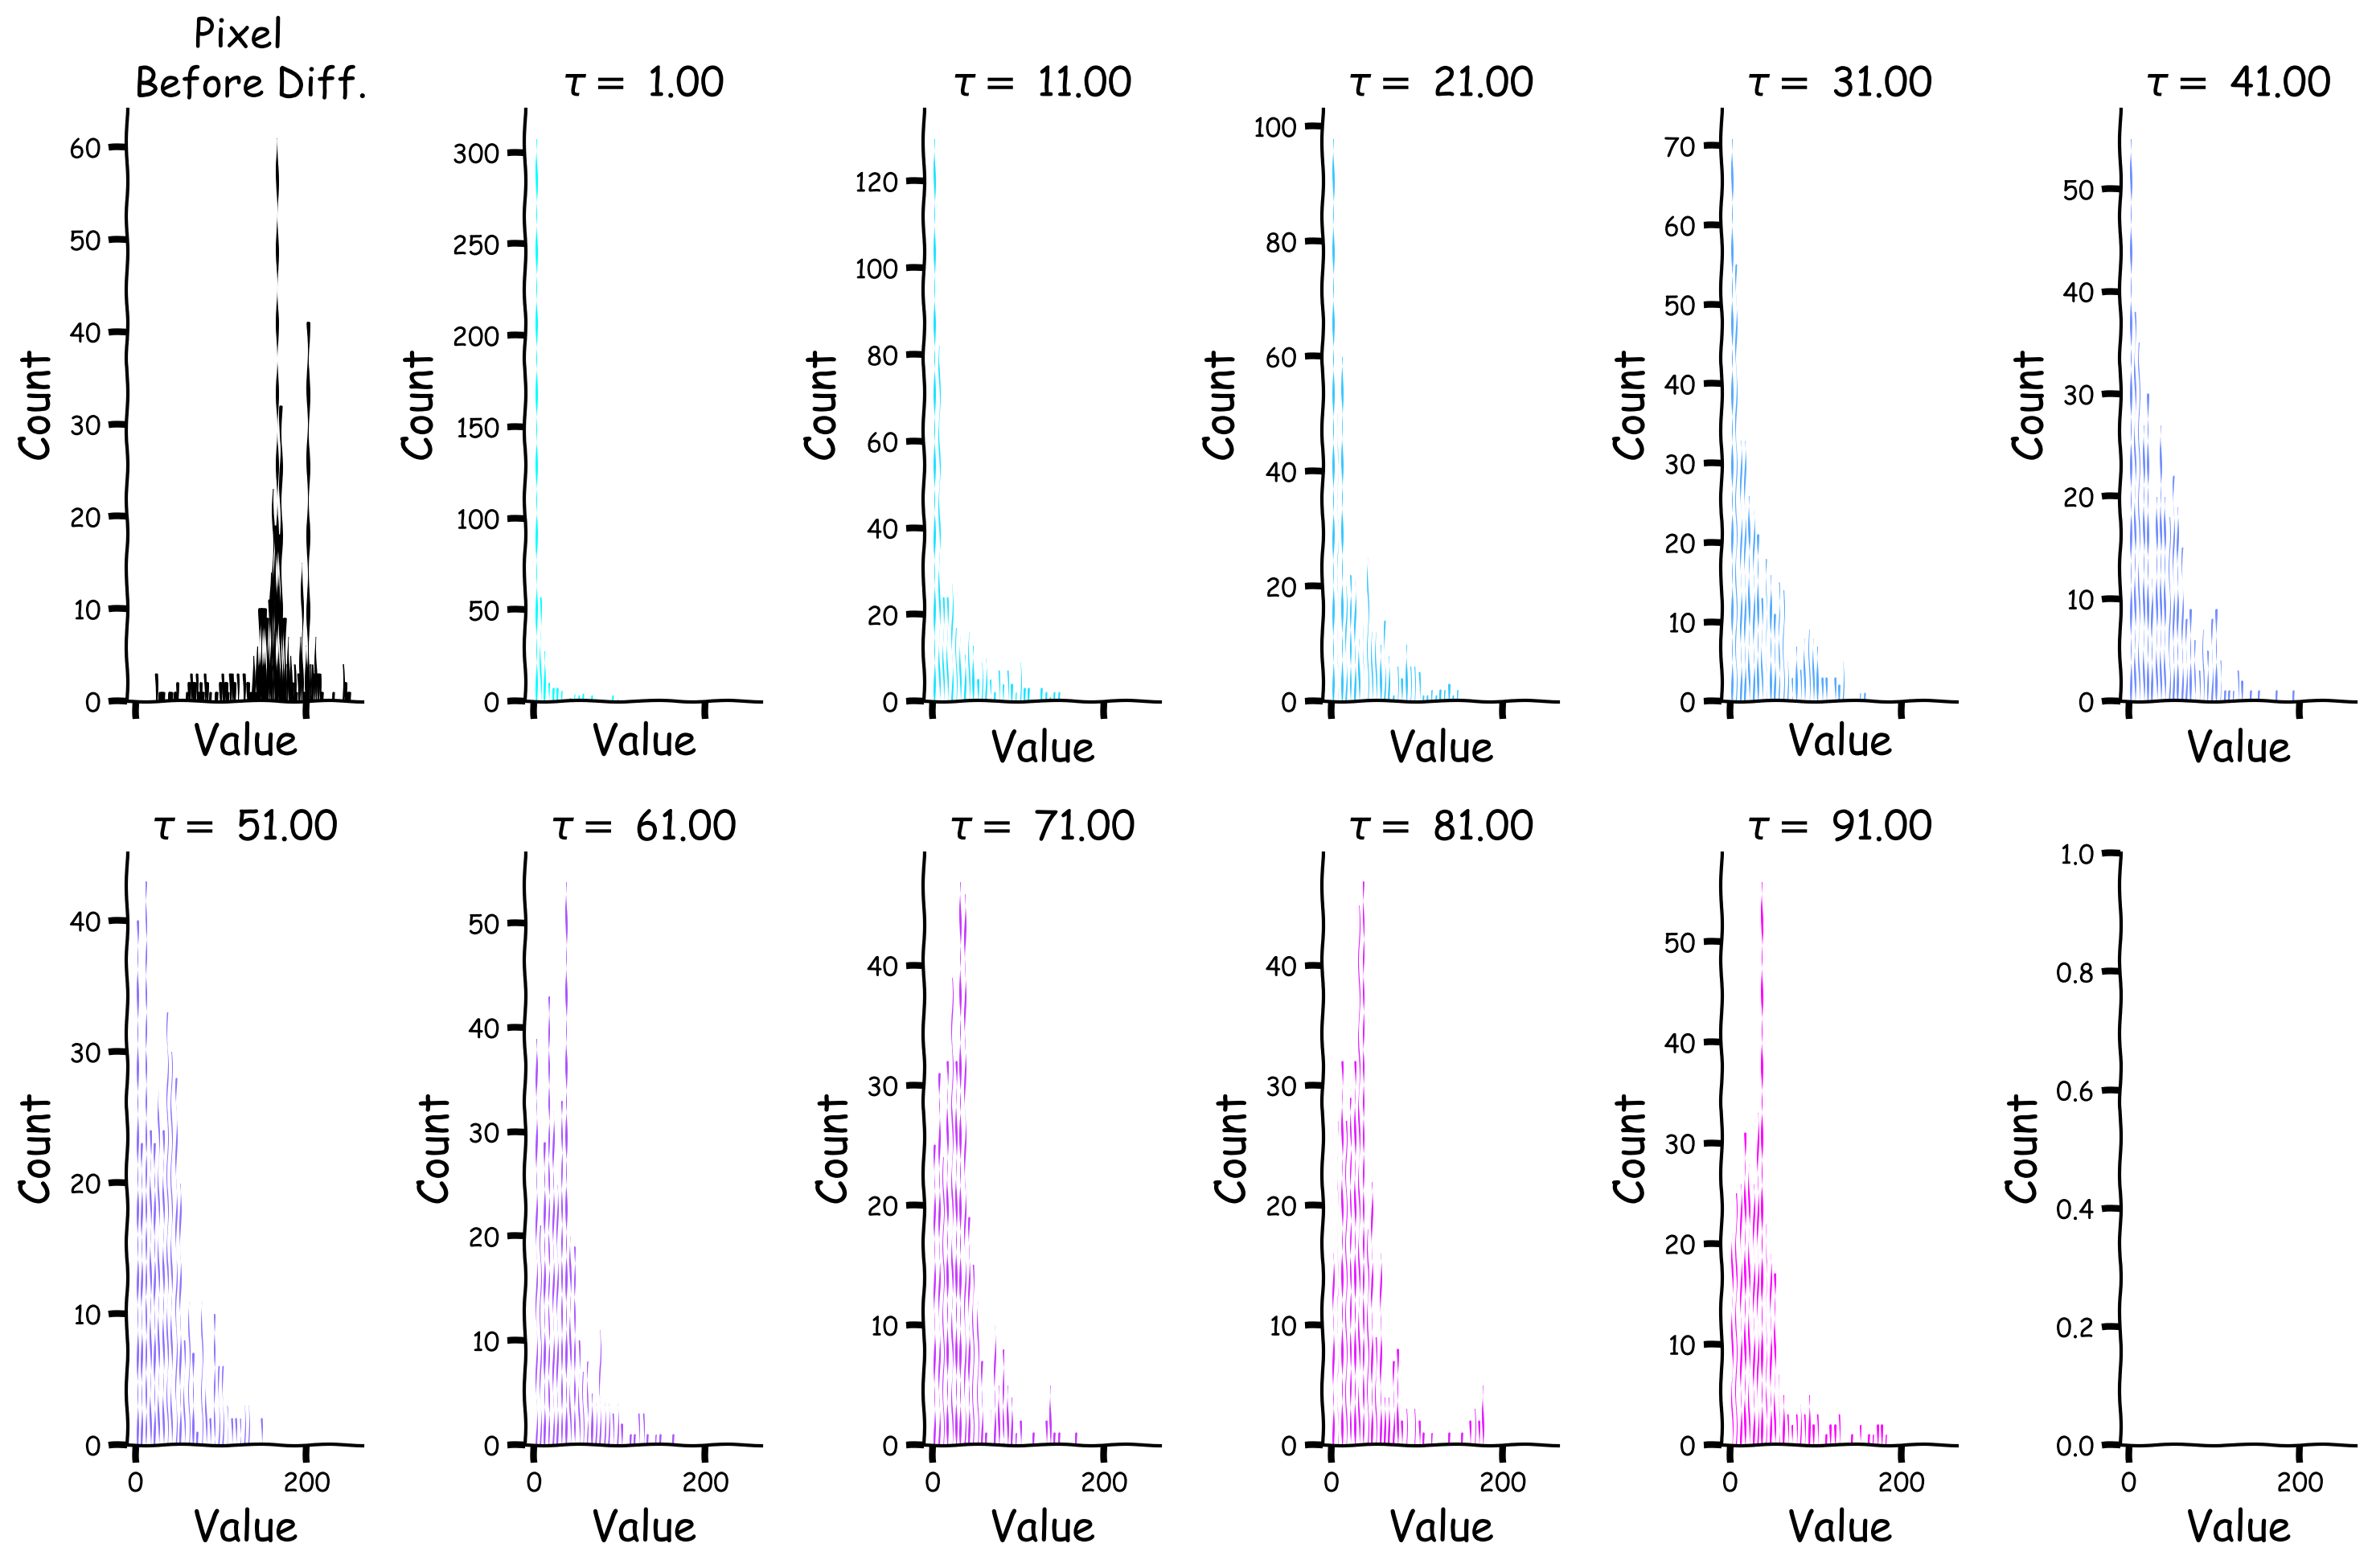

In [14]:
# @title Histogram plots for different values of $\tau$
plot_temp_diff_separate_histograms(sig, taus, taus_list)

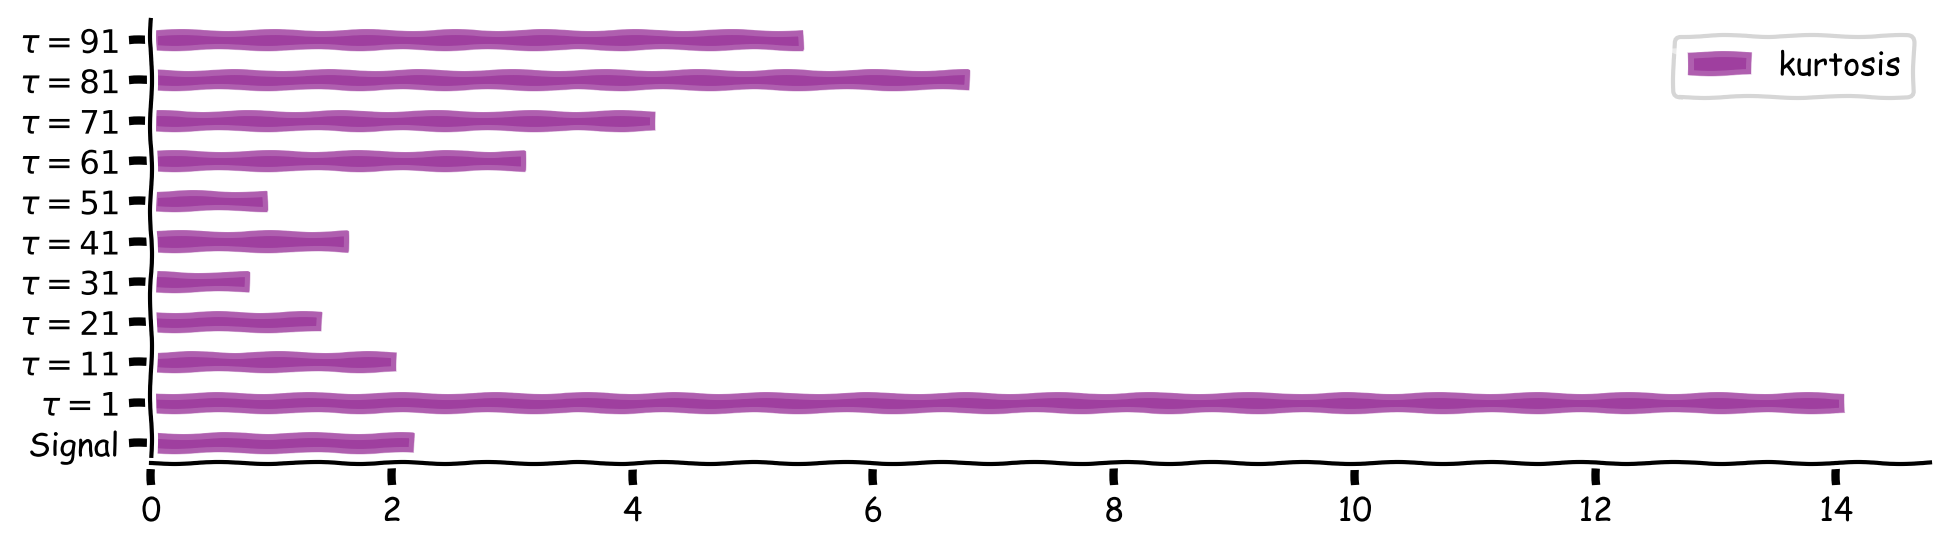

In [15]:
# @title Plot sparsity (kurtosis) for different values of $\tau$
plot_temp_diff_kurtosis(sig, taus, taus_list)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_increasing_the temporal_differcing_intervals")

### Exploring temporal differencing with a box filter

Instead of differences separated by delay $\tau$, we'll compute differences between one value and the average over a *range* of delays. This is closer to what brains actually do. Here we'll use a box filter for the average.

We define a `diff_box` function, which accepts a signal and the window size as inputs. Internally, it computes the difference between the signal and the average signal over a delayed time window. Observe the results for `window = 10`. We will explore changes at different times scales by choosing different window sizes and then comparing the raw signal with its `diff_box` temporal derivatives for each size.

In [ ]:
# @title Filter visualization

def diff_box(data, window, pad_size = 4):
    filter = np.concatenate([np.repeat(0,pad_size), np.repeat(0,window), np.array([1]), np.repeat(-1,window), np.repeat(0,pad_size)]).astype(float)
    filter /= np.sum(filter**2)**0.5

    filter_plus_sum =  filter[filter > 0].sum()
    filter_min_sum = np.abs(filter[filter < 0]).sum()
    filter[filter > 0] *= filter_min_sum/filter_plus_sum
    diff_box = np.convolve(data, filter, mode='full')[:len(data)]
    diff_box[:window] = diff_box[window]
    return diff_box, filter

window = 10
diff_box_signal, filter = diff_box(sig, window)

with plt.xkcd():
    fig, ax = plt.subplots()
    plot_e1 = np.arange(len(filter))
    plot_e2 = np.arange(len(filter)) + 1
    plot_edge_mean = 0.5*(plot_e1 + plot_e2)
    plot_edge = lists2list( [[e1 , e2] for e1 , e2 in zip(plot_e1, plot_e2)])
    ax.plot(plot_edge, np.repeat(filter, 2), alpha = 0.3, color = 'purple')
    ax.scatter(plot_edge_mean, filter, color = 'purple')
    add_labels(ax,ylabel = 'Filter Value', title = 'Box Filter', xlabel = 'Value')

#### Discussion

1. Why do you think the filter is asymmetric?
2. How might a filter influence the sparsity patterns observed in data?

In [ ]:
#to_remove explanation

"""
Discussion: 1. Why do you think the filter is asymmetric?
2. How might a filter influence the sparsity patterns observed in data?

1. As the filter reflects how we process time series data, it accounts for the past & for the future with different powers. Particularly, for this filter, past information is not included in the result at all, while the future one is evenly distributed for the defined window size.
2. Note that the filter takes the average of the future (not only one point of time). Thus, it would be much smoother than the regular one.
""";

In [ ]:
# @title Plot signal and its temporal derivative on a longer timescale
plot_diff_box(sig, filter, diff_box_signal)

Now, we will define the window for 10 different values: `windows = [1,11,21,...91]` and calculate corresponding `diff_box` signal versions.

In [ ]:
# @title Define different window values
windows = np.linspace(1, 91, 10)
diff_box_values = [diff_box(sig, int(window))[0] for window in windows]

In [ ]:
# @title Visualize temporal differences for different window sizes

plot_diff_with_diff_box(sig, windows, diff_box_values)

In [ ]:
# @title Histogram for each of the window size

plot_temp_diff_separate_histograms(sig, windows, diff_box_values, tau = False)

In [ ]:
# @title Compare sparsity (measured by kurtosis) for different window sizes

plot_temp_diff_kurtosis(sig, windows, diff_box_values, tau = False)

#### Discussion

1. What do you observe about the kurtosis after applying the temporal differentiation?

In [ ]:
#to_remove explanation

"""
Discussion: What do you observe about the kurtosis after applying the temporal differentiation?

In general, kurtosis value becomes higher, meaning that temporal differentiation makes the signal more concentrated.
""";

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_exploring_temporal_differencing_with_a_box_filter")

At the very end of the notebook, you can find a bonus section on spatial sparsity. We recommend you check it out if you are going to have time after going through the main materials of this day!

---
# Section 3: Sparse coding

*Estimated timing to here from start of tutorial: 35 minutes.*

*Sparse coding* is a coding strategy where the inputs are represented by a linear combination of features, most with zero coefficients but a few that are nonzero or active. Often, this is applied with an overcomplete basis set: we use more features that are necessary to cover the input space. This concept is often applied to sensory inputs, such as images or sounds, where the goal is to find a concise and efficient representation that captures the essential features of the input.

In Section 3.1, we assume that the basis set is fixed and known, and we just want to find sparse coefficients (or activities) that best explain the input data.

In Section 3.2, we then describe how to find a good basis set for use in sparse coding.

---
## Section 3.1: Finding coefficients for sparse codes

In [ ]:
# @title Video 4: Sparse coding

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'TkfPF24CZfk'), ('Bilibili', 'BV1sJ4m1u7Ed')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_sparse_coding")

### Neuroscience measures of sparse responses

In a pivotal experiment [1] at Johns Hopkins University, Hubel and Wiesel implanted an electrode into the visual cortex of a living cat and measured its electrical activity in response to displayed images.

Despite prolonged exposure to various images, no significant activity was recorded.

However, unexpectedly, when the slide was inserted and removed from the projector, the neurons responded robustly. This led to the discovery of neurons highly sensitive to **edge orientation and location**, providing the first insights into the type of information coded by neurons.


[1] *Hubel DH, Wiesel TN (1962). ["Receptive fields, binocular interaction and functional architecture in the cat's visual cortex."](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1359523/) J. Physiol.160, 106-154.*

### Discussion

1. What implications do these specialized properties of neural representation hold for our understanding of visual perception?
2. How might these findings inform computational models of visual processing in artificial systems?

### Computational Neuroscience model of sparse coding

In 1996, Olshausen and Field [2] demonstrated that sparse coding could be a good model of the early visual system, particularly in V1. They found that neuron selectivity in the visual cortex could be explained through **sparse coding**, where only *a small subset of neurons responded to specific features or patterns*.
Receptive fields learned through this objective looked like orientation-specific edge detectors, like those in biological visual systems, as we will see below.

[2] *Olshausen BA, Field DJ (1996). ["Emergence of simple-cell receptive field properties by learning a sparse code for natural images."](https://www.nature.com/articles/381607a0) Nature 381: 607-609.*

### $\ell_0$ pseudo-norm regularization to promote sparsity

The $\ell_0$ pseudo-norm is defined as the number of non-zero features in the signal. Particularly, let $h \in \mathbb{R}^{J}$ be a vector with $J$ "latent activity" features. Then:

$$\|h\|_0 = \sum_{j = 1}^J \mathbb{1}_{h_{j} \neq 0}$$

Hence, the  $\|\ell\|_0$ pseudo-norm can be used to promote sparsity by adding it to a cost function to "punish" the number of non-zero features.

Let's assume that we have a simple linear model where we want to capture the observations $y$ using the linear model $D$ (which we will later call dictionary). $D$'s features (columns) can have sparse weights denoted by $h$. This is known as a generative model, as it generates the sensory input. 

For instance, in the brain, $D$ can represent a basis of neuronal networks while $h$ can capture their sparse time-changing contributions to the overall brain activity (e.g. see the dLDS model in [3]). 

Hence, we are looking for the weights $h$ under the assumption that:

$$ y = Dh + \epsilon$$

where $\epsilon$ is an *i.i.d* Gaussian noise with zero mean and std of $\sigma_\epsilon$, i.e., $\epsilon \sim \mathcal{N}(0, \sigma_\epsilon^2)$.

To enforce that $h$ is sparse, we penalize the number of non-zero features with penalty $\lambda$. We thus want to solve the following minimization problem:

$$
\hat{h} = \arg \min_x \|y - Dh \|_2^2 + \lambda \|h\|_0
$$

[3] Mudrik, N., Chen, Y., Yezerets, E., Rozell, C. J., & Charles, A. S. (2024). Decomposed linear dynamical systems (dlds) for learning the latent components of neural dynamics. Journal of Machine Learning Research, 25(59), 1-44.

![Features to data.](https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D5_Microcircuits/static/dictionary.png?raw=true)

In the above figure and throughout this tutorial, we will use the following definitions:

- **$D$:** Dictionary
- **Features:** Refers to the columns of $D$ (i.e., basis elements)
- **Basis:** Refers to the collection of features
- **$h$:** A sparse vector assigning weights to the elements of $D$

These definitions will help clarify the terminology used in discussing the concepts of dictionary learning and sparse coding.

### How can we find the sparse vector $h$ given a dictionary?

One method to find a sparse solution for a linear decomposition with $\ell_0$ regularization is OMP (Orthogonal Matching Pursuit) [4]. As explained in the video, OMP is an approximate method to find the best matching features to represent a target signal.

OMP iteratively selects the features that best correlate with the remaining part of the signal, updates the remaining part by subtracting the contribution of the chosen features, and repeats until the remaining part is minimized or the desired number of features is selected.

In this context, a "dictionary" is a collection of features that we use to represent the target signal. These features are like building blocks, and the goal of the OMP algorithm is to find the right combination of these blocks from the dictionary to match the target signal best.

[4] Pati, Y. C., Rezaiifar, R., & Krishnaprasad, P. S. (1993, November). ["Orthogonal matching pursuit: Recursive function approximation with applications to wavelet decomposition."](https://www.khoury.northeastern.edu/home/eelhami/courses/EE290A/OMP_Krishnaprasad.pdf) In Proceedings of 27th Asilomar conference on signals, systems, and computers (pp. 40-44). IEEE.

### Coding Exercise 3: OMP algorithm

Now, we will explore the Orthogonal Matching Pursuit (OMP) algorithm with increasing sparsity levels and examine how pixel values are captured by different frequencies.

**We will follow the following steps:**

1. Generate sinusoidal features with varying frequencies ranging from 0.001 to 1, applying each frequency to a time array. These features will serve in this exercise as the dictionary.
   
2. Implement the OMP algorithm with increasing sparsity levels. Feel free to change the number of non-zero coefficients (in `n_nonzero_coefs` to explore its effect.

3. Fit the generated sinusoidal signals to the dictionary of frequencies you defined.

4. Evaluate how well each sparsity level captures the variations in features.

5. Explore the results to understand the trade-off between sparsity and the accuracy of signal representation.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete OMP algorithm preparation.")
###################################################################
T_ar = np.arange(len(sig))

#100 different frequency values from 0.001 to 1, then apply each frequency on `T_ar`
freqs = np.linspace(0.001, 1, ...)
set_sigs = [np.sin(...*...) for f in freqs]

# define 'reg' --- an sklearn object of OrthogonalMatchingPursuit, and fit it to the data, where the frequency bases are the features and the signal is the label
reg = OrthogonalMatchingPursuit(fit_intercept = True, n_nonzero_coefs = 10).fit(np.vstack(set_sigs).T, sig)

In [ ]:
#to_remove solution
T_ar = np.arange(len(sig))

#100 different frequency values from 0.001 to 1, then apply each frequency on `T_ar`
freqs = np.linspace(0.001, 1, 100)
set_sigs = [np.sin(T_ar*f) for f in freqs]

# define 'reg' --- an sklearn object of OrthogonalMatchingPursuit, and fit it to the data, where the frequency bases are the features and the signal is the label
reg = OrthogonalMatchingPursuit(fit_intercept = True, n_nonzero_coefs = 10).fit(np.vstack(set_sigs).T, sig)

Observe the plot of 3 example signals.

In [ ]:
# @title Plot of 3 basis signals

with plt.xkcd():
    fig, axs = plt.subplots(3,1,sharex = True, figsize = (10,5), sharey = True)
    axs[0].plot(set_sigs[0], lw = 3)
    axs[1].plot(set_sigs[1], lw = 3)
    axs[2].plot(set_sigs[-1], lw = 3)
    [remove_edges(ax) for ax in axs]
    [ax.set_xlim(left = 0) for ax in axs]
    fig.tight_layout()

Next, run the following code to plot the basis features and the reconstruction.

In [ ]:
# @title Visualize basis features and signal reconstruction

with plt.xkcd():
    fig, axs = plt.subplots(2,2, figsize = (15,10))
    axs = axs.flatten()

    sns.heatmap(np.vstack(set_sigs), ax = axs[0])
    axs[0].set_yticks(np.arange(0,len(freqs)-.5, 4)+ 0.5)
    axs[0].set_yticklabels(['$f = %.4f$'%freqs[int(j)] for j in np.arange(0,len(freqs)-0.5, 4)], rotation = 0)
    add_labels(axs[0], xlabel = 'Time', ylabel= 'Basis Features', title = 'Frequency Basis Features')

    axs[1].plot(sig, label = 'Original', lw = 4)
    axs[1].plot(reg.predict(np.vstack(set_sigs).T), lw = 4, label = 'Reconstruction')
    remove_edges(axs[1])
    axs[1].legend()
    add_labels(axs[1], xlabel = 'Time', ylabel= 'Signal', title = 'Reconstruction')
    axs[1].set_xlim(left = 0)

    axs[2].stem(freqs, reg.coef_)
    remove_edges(axs[2])
    add_labels(axs[2], xlabel = 'Frequencies', ylabel= 'Frequency weight', title = 'Frequency Components Contributions')
    axs[2].set_xlim(left = 0)

    num_colors = np.sum(reg.coef_ != 0)
    cmap_name = 'winter'
    samples = np.linspace(0, 1, num_colors)
    colors = plt.colormaps[cmap_name](samples)
    colors_expand = np.zeros((len(reg.coef_), 4))
    colors_expand[reg.coef_!= 0] = np.vstack(colors)

    axs[-1].plot(sig, label = 'Original', color = 'black')
    [axs[-1].plot(reg.coef_[j]*set_sigs[j] + reg.intercept_, label = '$f = %.4f$'%f, lw = 4, color = colors_expand[j]) for j, f in enumerate(freqs) if  reg.coef_[j] != 0]
    remove_edges(axs[-1])
    axs[-1].legend(ncol = 4)
    axs[-1].set_xlim(left = 0)
    add_labels(axs[-1], xlabel = 'Time', ylabel= 'Signal', title = 'Contribution')

Now, we will explore the effect of increasing the number of non-zero coefficients.
Below, please run OMP with increasing numbers of non-zero coefficients, from 1 to 101 in intervals of 5.
We will then compare the accuracy and reconstruction performance of each order.

In [ ]:
# @title OMP for different cardinality

# define a list or numpy array of optional cardinalities from 1 to 51 in intervals of 5.
cardinalities = np.arange(1,101,5)

# For each of the optional cardinalities, run OMP using the pixel's signal from before. Create a list called "regs" that includes all OMP's fitted objects
regs = [OrthogonalMatchingPursuit(fit_intercept = True, n_nonzero_coefs = card).fit(np.vstack(set_sigs).T, sig) for card in cardinalities]

Now, let's observe the effect of the cardinality on the reconstruction.

In [ ]:
# @title Cardinality impact on reconstruction quality

with plt.xkcd():
    fig, axs = plt.subplots(1, 2, figsize = (15,5))
    ax = axs[0]
    ax.plot(cardinalities, [reg.score(np.vstack(set_sigs).T, sig) for reg in regs], marker = '.')

    ax.set_xlim(left = 0)
    ax.set_ylim(bottom = 0)
    add_labels(ax, ylabel = 'coefficient of determination', xlabel  = 'Cardinality')
    remove_edges(ax)
    mean_er = np.vstack([np.mean((reg.predict(np.vstack(set_sigs).T) - sig)**2)**0.5 for reg in regs])

    axs[1].plot(cardinalities, mean_er)
    axs[1].set_xlim(left = 0)
    axs[1].set_ylim(bottom = 0)
    remove_edges(axs[1])
    add_labels(axs[1], ylabel = 'rMSE', xlabel  = 'Cardinality')
    plt.show()

**How would you choose the ideal cardinality?**

- Hint: Look for an 'ankle' in complexity vs. sparsity plots, which indicates a balance between expressivity and sparsity. Discuss these observations with your group to determine the most effective cardinality.

**How does the above affect generalization?**

- Hint: Consider how learning fewer but most relevant features from noisy data might help the model generalize better to new, unseen data.

**What is your conclusion?**

- Hint: Discuss how sparsity, which emphasizes few significant features, improves the model's robustness and utility in real-world scenarios and the considerations needed when setting the level of sparsity.

In [ ]:
# @title Identifying Sparse Contributions Across Frequencies

with plt.xkcd():
    fig, axs = plt.subplots(5, int(len(cardinalities)/5), figsize = (15,20),sharey = False, sharex = True)
    axs = axs.flatten()
    for j, (ax,reg) in enumerate(zip(axs,regs)):
      ax.stem(freqs, reg.coef_)
      remove_edges(ax)
      add_labels(ax, xlabel = 'Frequencies', ylabel= 'Frequency weight', title = 'Cardinality %d'%cardinalities[j])
      ax.set_xlim(left = 0)
    fig.tight_layout()
    plt.show()

**Challenges with OMP**

While OMP is a common and simple practice for finding the sparse representation of a dictionary of features, it presents multiple challenges. The $\ell_0$ norm is not convex, making it hard to identify the sparse vector. Another challenge is computational complexity. Approaches addressing these issues exist. Some of them replace the $\ell_0$ norm with its $\ell_1$ approximation, promoting sparsity while retaining convexity, making it easier to optimize.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_omp_algorithm")

---
## Section 3.2: Hidden features as dictionary learning

*Estimated timing to here from start of tutorial: 55 minutes.*

In [ ]:
# @title Video 5: Dictionary learning

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'k6W4acjVOkg'), ('Bilibili', 'BV17M4m1U7fQ')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_dictionary_learning")

### What if we do not know the dictionary of features?

In OMP, we've assumed that we already know the features and are solely focused on identifying which sparse combination can best describe the data. However, in real-world scenarios, we frequently lack knowledge about the fundamental components underlying the data. In other words, we don't know the features and must learn them.

**Dictionary Learning:**
To address this problem, Dictionary Learning aims to simultaneously learn both the dictionary of features and the sparse representation of the data. It iteratively updates the dictionary and the sparse codes until convergence, typically minimizing a reconstruction error term along with a sparsity-inducing regularizer.

**How is it related to the brain?**
Dictionary Learning draws parallels to the visual system's ability to extract features from raw sensory input. In the brain, the visual system processes raw visual stimuli through hierarchical layers, extracting increasingly complex features at each stage. Similarly, Dictionary Learning aims to decompose complex data into simpler components, akin to how the visual system breaks down images into basic visual features like edges and textures.

Now, let's apply Dictionary Learning to various types of data to unveil the latent components underlying it.

### Coding Exercise 4: Dictionary Learning for MNIST

In this exercise, we first load a new short video created from MNIST images, as shown below. We then use sklearn's `DictionaryLearning` to find the dictionary's ($D$) features.

In particular, we will follow the following steps:

1) **Load the Video Data**: Begin by loading the 3D video data from the `reweight_digits.npy` file, which contains pixel data over time.

2) **Preprocess the Video Data**: Create a copy of the video data to work on without altering the original data. Extract the total number of frames, as well as the dimensions of each frame, adjusting for any specific modifications (e.g., reducing the width by 10 columns).

3) **Prepare Frames for Analysis**: Flatten each frame of the video to convert the 2D image data into 1D vectors. Store these vectors in a list, which is then converted into a NumPy array for efficient processing.

4) **Initialize Dictionary Learning**: Set up a dictionary learning model with specific parameters (e.g., number of components, the algorithm for transformation, regularization strength, and random state for reproducibility).

5) **Fit and Transform the Data (YOUR EXERCISE)**: Fit the dictionary learning model to the prepared video data and transform it to obtain sparse representations. This involves completing the implementation of `dict_learner.fit(...).transform(...)` by providing the necessary input arguments based on your tutorial's context.
Pay attention, as usual, you will need to remove the placeholder `raise NotImplementedError` and replace it with the appropriate function call to `fit` and `transform` the data.

In [ ]:
###################################################################
## Fill out the following then remove.
raise NotImplementedError("Student exercise: complete calcualtion of `D_transformed`.")
###################################################################

# Video_file is a 3D array representing pixels X pixels X time
video_file = np.load('reweight_digits.npy')

# Create a copy of the video_fire array
im_focus = video_file.copy()

# Get the number of frames in the video
T = im_focus.shape[2]

# Get the number of rows in the video
N0 = im_focus.shape[0]

# Get the number of columns in the video, leaving out 10 columns
N1 = im_focus.shape[1] - 10

# Create a copy of the extracted frames
low_res = im_focus.copy()

# Get the shape of a single frame
shape_frame = low_res[:, :, 0].shape

# Flatten each frame and store them in a list
video_file_ar = [low_res[:, :, frame].flatten() for frame in range(low_res.shape[2])]

# Create dict_learner object
dict_learner = DictionaryLearning(
    n_components=15, transform_algorithm='lasso_lars', transform_alpha=0.9,
    random_state=402,
)

# List to np.array
video_v = np.vstack(video_file_ar)

# Fit and transform `video_v`
D_transformed = dict_learner.fit(...).transform(...)

In [ ]:
#to_remove solution
# Video_file is a 3D array representing pixels X pixels X time
video_file = np.load('reweight_digits.npy')

# Create a copy of the video_fire array
im_focus = video_file.copy()

# Get the number of frames in the video
T = im_focus.shape[2]

# Get the number of rows in the video
N0 = im_focus.shape[0]

# Get the number of columns in the video, leaving out 10 columns
N1 = im_focus.shape[1] - 10

# Create a copy of the extracted frames
low_res = im_focus.copy()

# Get the shape of a single frame
shape_frame = low_res[:, :, 0].shape

# Flatten each frame and store them in a list
video_file_ar = [low_res[:, :, frame].flatten() for frame in range(low_res.shape[2])]

# Create dict_learner object
dict_learner = DictionaryLearning(
    n_components=15, transform_algorithm='lasso_lars', transform_alpha=0.9,
    random_state=402,
)

# List to np.array
video_v = np.vstack(video_file_ar)

# Fit and transform `video_v`
D_transformed = dict_learner.fit(video_v).transform(video_v)

Let's visualize the identified features!

In [ ]:
# @title Visualization of features

with plt.xkcd():
    num_thetas = 20
    cmap_name = 'plasma'
    samples = np.linspace(0, 1, len(dict_learner.components_)+1)
    colors = plt.colormaps[cmap_name](samples)

    num_comps = len(dict_learner.components_)

    fig, axs = plt.subplots(2, int((1+num_comps)/2) , figsize = (16,4), sharey = True, sharex = True)
    axs = axs.flatten()
    [sns.heatmap(dict_learner.components_[j].reshape(shape_frame), square = True, cmap ='gray', robust = True, ax = axs[j]) for j in range(num_comps)]
    titles = ['Atom %d'%j for j in range(1, num_comps +1)]
    [ax.set_title(title, color = colors[j], fontsize = 10)
    for j, (title, ax) in enumerate(zip(titles, axs))]
    axs[-1].set_visible(False)

In [ ]:
# @title Visualization of impact of features through the time

D = np.linalg.pinv(dict_learner.components_.T) @ video_v.T
D_transformed_norm = D.T.copy()
with plt.xkcd():
    fig, ax = plt.subplots(figsize = (16,3))
    [ax.plot(D_transformed_norm[:,j], color = colors[j], lw = 5, label = 'Atom %d'%(j+1))
     for j in range(num_comps)]
    remove_edges(ax)
    ax.set_xlim(left = 0)
    [ax.set_yticks([]) for ax in axs]
    [ax.set_xticks([]) for ax in axs]

    add_labels(ax, xlabel = 'Time', ylabel = 'Coefficients', title = 'Features Ceofficients')
    create_legend({'Atom %d'%(j+1): colors[j] for j in range(num_comps)},
                  params_leg = {'ncol': 3})

Now, let's compare the components to PCA.

In [ ]:
# @title PCA components visualization

data_mat = np.vstack(video_file_ar)
# Assuming your data is stored in a variable named 'data_mat' (N by p numpy array)
# where N is the number of samples and p is the number of features

# Create a PCA object with 20 components
pca = PCA(n_components=15)

# Fit the PCA model to the data
pca.fit(data_mat)

# Access the 20 PCA components
pca_components = pca.components_

pca_componens_images = [pca_components[comp,:].reshape(shape_frame) for comp in range(num_comps)]

with plt.xkcd():
    fig, axs = plt.subplots(2, int((1+num_comps)/2) , figsize = (16,4), sharey = True, sharex = True)
    axs = axs.flatten()
    [sns.heatmap(im, ax = axs[j], square = True, cmap ='gray', robust = True) for j,im in enumerate(pca_componens_images)]
    titles = ['Atom %d'%j for j in range(1, num_comps +1)]
    [ax.set_title(title, color = colors[j], fontsize = 10) for j, (title, ax) in enumerate(zip(titles, axs))]
    axs[-1].set_visible(False)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_dictionary_learning_for_mnist")

---
# Section 4: Identifying sparse visual fields in natural images using sparse coding

*Estimated timing to here from start of tutorial: 1 hour 5 minutes.*

In this section we will understand the basis of visual field perception.

In [ ]:
# @title Video 6: Sparse visual fields

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'zqmrxK_N6Jw'), ('Bilibili', 'BV1Pi421v7Wk')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_sparse_visual_fields")

## Dictionary Learning for CIFAR10

We will use the CIFAR10 dataset. Let's, at first, load the data.

In [ ]:
# @title Load CIFAR-10 dataset

import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

Now, let's create a short video of these images switching. Now, we will detect the underlying visual fields.

In [ ]:
# @title Create & explore video

num_image_show = 50
img_index = np.random.randint(0, len(x_train), num_image_show)
x_train_ar = np.copy(x_train)[img_index]
video_gray = 0.2989 * x_train_ar[:, :, :,0] + 0.5870 * x_train_ar[:, :, :,1] + 0.1140 * x_train_ar[:, :, :,2]

def show_slice_CIFAR(slice_index):
    with plt.xkcd():
        plt.figure(figsize=(2, 2))
        plt.imshow(data_CIFAR[slice_index] , cmap='gray')
        plt.axis('off')
        plt.show()

data_CIFAR = np.repeat(video_gray, 1, axis = 0)

# Create a slider to select the slice
slider = IntSlider(min=0, max=data_CIFAR.shape[0] - 1, step=1, value=0, description='Frame')

# Connect the slider and the function
interact(show_slice_CIFAR, slice_index=slider)

Now, let's try to extract the visual field from the images. Look at the components identified below and compare the ones identified by PCA to those identified by Olshausen & Field via sparse dictionary learning.

![Components comparison.](https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D5_Microcircuits/static/components.png?raw=true)

Following Olshausen & Field's paper, we will demonstrate how to receive visual field components that emerge from real-world images.

We expect to find features that are:
1.   Spatially localized.
2.   Oriented.
3.   Selective to structure at different spatial scales.

We would like to understand the receptive field properties of neurons in the visual cortex by applying sparsity to identify the basic fundamental components underlying natural images.

We will reshape the CIFAR data we loaded before so that the time (frame) axis is the last one.

In [ ]:
video_file = data_CIFAR.transpose((1,2,0))

For the exercise, we will focus on a small subset of the data so that you can understand the idea. We will later load better results trained for a longer time.

We will first set some parameters to take a small subset of the video. In the cell below, you can explore parameters that are set by default.

In [ ]:
# @title Set default parameters

size_check =  4 # 32 for the full size

# how many images we want to consider? (choose larger numbers for better results)
num_frames_include =  80

# set number of dictionary features
dict_comp = 8

# set number of model iterations
max_iter = 100

num_frames_include = np.min([num_frames_include , x_train.shape[0]])

Let's visualize the small subset we are taking for the training.

In [ ]:
# @title Images visualization

# let's choose some random images to focus on
img_index = np.random.randint(0, len(x_train), num_frames_include)
x_train_ar = np.copy(x_train)[img_index]

# change to grayscale
video_gray = 0.2989 * x_train_ar[:, :, :,0] + 0.5870 * x_train_ar[:, :, :,1] + 0.1140 * x_train_ar[:, :, :,2]

# update data and create short movie
data_CIFAR = np.repeat(video_gray, 1, axis = 0)

# Create a slider to select the slice
slider = IntSlider(min=0, max=data_CIFAR.shape[0] - 1, step=1, value=0, description='Frame')

# Connect the slider and the function
interact(show_slice_CIFAR, slice_index=slider)

### Coding Exercise 5: Find the latent components by training the dictionary learner
Training time will take around 1 minute.

*Please follow the following steps:*

**Choose Alpha ($\alpha$)**:
   - Each group member should select a unique value for $\alpha$ between approximately ~0.0001 and ~1.
   - $\alpha$ controls the sparsity of the learned dictionary components in the DictionaryLearning algorithm.
   - **Discussion**: Before running the model, discuss your expectations on how different $\alpha$ values might affect the sparsity and quality of learned features.

**Apply Dictionary Learning**:
   - Use the chosen $\alpha$ to fit the DictionaryLearning model (`dict_learner`).
   - Compare and document how each $\alpha$ (selected by different group members)  influences the sparsity and quality of learned dictionary components. 
   *Note: Each member should choose only one $\alpha$ due to computational constraints.*

**Visualize Results**:
   - Plot heatmap visualizations (`sns.heatmap`) to examine individual dictionary components for each $\alpha$ value.
   - Plot coefficients over time (`D_transformed`) to analyze and compare how they vary across different $\alpha$ values.

**Group Discussion**:
   - Compare your results with peers who selected different $\alpha$ values.
   - Discuss and interpret the impact of $\alpha$ on sparsity and feature representation.
   - Summarize findings on which $\alpha$ values appear most effective for achieving desired sparsity and representation quality.

In [ ]:
# Get the number of frames in the video
T = video_file.shape[2]

# Get the number of rows in the video
N0 = video_file.shape[0]

# Get the number of columns in the video, leaving out 10 columns
N1 = video_file.shape[1] - 10

# Get the shape of a single frame
shape_frame = video_file[:, :, 0].shape

# Flatten each frame and store them in a list
num_frames_include = np.min([num_frames_include, video_file.shape[2]])

size_check = np.min([size_check, video_file.shape[0]])

video_file_ar = [video_file[:size_check, :size_check, frame].flatten() for frame in range(num_frames_include)]

###################################################################
## Fill out the following then remove.
raise NotImplementedError("Student exercise: please choose an $\alpha$ value here. Recommended $0.0001 <= \alpha <= 1$")
###################################################################

alpha = ...

dict_learner = DictionaryLearning(
    n_components=dict_comp, transform_algorithm = 'lasso_lars', transform_alpha=alpha,
    random_state=42,
)

D_transformed = dict_learner.fit_transform(np.vstack(video_file_ar))

with plt.xkcd():
    num_rows = 3
    num_cols =  int(( num_frames_include + 2)/num_rows)
    shape_frame = (size_check,size_check)

    cmap_name = 'plasma'
    samples = np.linspace(0, 1, len(dict_learner.components_)+1)
    colors = plt.colormaps[cmap_name](samples)
    num_comps = len(dict_learner.components_)

    vmin =  np.min(np.vstack(dict_learner.components_))
    vmax = np.max(np.vstack(dict_learner.components_))


    [sns.heatmap(dict_learner.components_[j].reshape(shape_frame), ax = axs[j], square = True, vmin = vmin, vmax = vmax,
                  cmap = 'PiYG', center = 0, cbar = False)  for j in range(num_comps)]

    [ax.set_xticks([]) for ax in axs]
    [ax.set_yticks([]) for ax in axs]

    titles = ['Atom %d'%j for j in range(1, num_comps +1)];
    [ax.set_title(title,  fontsize = 40) for j, (title, ax) in enumerate(zip(titles, axs))]


    fig, ax = plt.subplots(figsize = (20,5))
    [ax.plot(D_transformed[:,j],  lw = 5, label = 'Atom %d'%(j+1))
      for j in range(num_comps)]
    remove_edges(ax)
    ax.set_xlim(left = 0)
    [ax.set_yticks([]) for ax in axs]
    [ax.set_xticks([]) for ax in axs]

    add_labels(ax, xlabel = 'Time', ylabel = 'Coefficients', title = "Features' Coefficients")
    fig.tight_layout()

In [ ]:
# Get the number of frames in the video
T = video_file.shape[2]

# Get the number of rows in the video
N0 = video_file.shape[0]

# Get the number of columns in the video, leaving out 10 columns
N1 = video_file.shape[1] - 10

# Get the shape of a single frame
shape_frame = video_file[:, :, 0].shape

# Flatten each frame and store them in a list
num_frames_include = np.min([num_frames_include, video_file.shape[2]])

size_check = np.min([size_check, video_file.shape[0]])

video_file_ar = [video_file[:size_check, :size_check, frame].flatten() for frame in range(num_frames_include)]


alpha = 0.5

dict_learner = DictionaryLearning(
    n_components=dict_comp, transform_algorithm = 'lasso_lars', transform_alpha=alpha,
    random_state=42,
)

D_transformed = dict_learner.fit_transform(np.vstack(video_file_ar))

with plt.xkcd():
    num_rows = 3
    num_cols =  int(( num_frames_include + 2)/num_rows)
    shape_frame = (size_check,size_check)

    cmap_name = 'plasma'
    samples = np.linspace(0, 1, len(dict_learner.components_)+1)
    colors = plt.colormaps[cmap_name](samples)
    num_comps = len(dict_learner.components_)

    vmin =  np.min(np.vstack(dict_learner.components_))
    vmax = np.max(np.vstack(dict_learner.components_))


    [sns.heatmap(dict_learner.components_[j].reshape(shape_frame), ax = axs[j], square = True, vmin = vmin, vmax = vmax,
                  cmap = 'PiYG', center = 0, cbar = False)  for j in range(num_comps)]

    [ax.set_xticks([]) for ax in axs]
    [ax.set_yticks([]) for ax in axs]

    titles = ['Atom %d'%j for j in range(1, num_comps +1)];
    [ax.set_title(title,  fontsize = 40) for j, (title, ax) in enumerate(zip(titles, axs))]


    fig, ax = plt.subplots(figsize = (20,5))
    [ax.plot(D_transformed[:,j],  lw = 5, label = 'Atom %d'%(j+1))
      for j in range(num_comps)]
    remove_edges(ax)
    ax.set_xlim(left = 0)
    [ax.set_yticks([]) for ax in axs]
    [ax.set_xticks([]) for ax in axs]

    add_labels(ax, xlabel = 'Time', ylabel = 'Coefficients', title = "Features' Coefficients")
    fig.tight_layout()

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_find_the_latent_components_by_training_the_dictionary_learner")

Due to our efforts to limit computation time, we focused on a small area of the images, and we only considered a limited number of them with a restricted number of iterations. As a result, the quality of the outcomes was poor. For your exploration, we are providing better results obtained from training on a larger amount of images.
This is important for discovering the components that better resemble the biological visual field.

In [ ]:
# @title Load full model & visualize features
res = np.load('model.npy', allow_pickle = True).item()
comps = res['dict_learner_components_']

with plt.xkcd():
    shape_frame = (32,32)

    cmap_name = 'plasma'
    samples = np.linspace(0, 1, len(comps)+1)
    colors = plt.colormaps[cmap_name](samples)
    num_comps = len(comps)

    vmin =  np.min(np.vstack(comps))
    vmax = np.max(np.vstack(comps))

    fig, axs = plt.subplots(2, int(np.ceil((num_comps+1)/2)) , figsize = (20,15), sharey = True, sharex = True)
    axs = axs.flatten()


    [axs[j].imshow(comps[j].reshape(shape_frame), vmin = 0)  for j in range(num_comps)]

    [ax.set_xticks([]) for ax in axs]
    [ax.set_yticks([]) for ax in axs]

    titles = ['Atom %d'%j for j in range(1, num_comps +1)];
    [ax.set_title(title,  fontsize = 40, color = colors[j]) for j, (title, ax) in enumerate(zip(titles, axs))]
    axs[-1].set_visible(False)
    axs[-2].set_visible(False)

In [ ]:
# @title Sparse Activity of the components ($h$)

D_transformed = res['X_transformed']

with plt.xkcd():
    fig, ax = plt.subplots(figsize = (20,5))
    [ax.plot(D_transformed[:,j], color = colors[j], lw = 5, label = 'Atom %d'%(j+1))
      for j in range(num_comps)]
    remove_edges(ax)
    ax.set_xlim(left = 0)
    [ax.set_yticks([]) for ax in axs]
    [ax.set_xticks([]) for ax in axs]

    add_labels(ax, xlabel = 'Time', ylabel = 'Coefficients', title = "Features' Coefficients")
    create_legend({'Atom %d'%(j+1): colors[j] for j in range(num_comps)}, params_leg = {'ncol': 5})

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_dictionary_learning_for_cifar10")

In this section, you've identified sparse components underlying natural images, similar to the approach taken by Olshausen and Field (1996) [2], which led to the widespread use of Dictionary Learning in research. 

Interestingly, applying sparsity to the number of active components is crucial and closely related to how the visual cortex, including V1, processes visual information.

As discovered in seminal experiments by Hubel and Wiesel [mentioned before in 1], neurons in V1 are tuned to respond optimally to specific, sparse patterns of visual stimuli—this represents an efficient data representation that minimizes redundancy while maximizing information content. 

This mechanism demonstrates that neurons in V1 intensely fire for certain edge orientations and light patterns, closely paralleling the sparse coding models used today in AI.

- How do you think these insights about V1 might enhance the algorithms you will develop in the field of neuroAI?
- What other neural mechanisms do you think utilize sparsity and can inspire AI research?


---
# Summary

*Estimated timing of tutorial: 1 hour 20 minutes.*

In this tutorial, we first discovered the notion of "sparsity" by looking at the signal and its temporal difference. We also introduced kurtosis as one of the main metrics used to measure sparsity and visually observed this effect by looking at the histograms of pixel values. Then, we introduced the notion of "sparse coding" by deriving fundamental units (basis) that constitute complex signals. For that, we used the OMP algorithm and compared the identified features to those found by applying PCA. In the end, we used the algorithm for 2 datasets: MNIST & CIFAR10.

In the next tutorial, we will look at another essential operation to be realized in brains & machines - normalization.

---
# Bonus Section 1: Sparsity in space

In this section, we will focus on spatial sparsity.

In [ ]:
# @title Bonus Video 1: Sparsity in space

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'bGH4NiD1Ye4'), ('Bilibili', 'BV1sT421a7MX')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_sparsity_in_space")

## Bonus Coding Excercise 1: Hard thresholding

Below, you can find the 1st frame, which we will focus on for the spatial differentiation (i.e., differentiation in space).

In [ ]:
# @title Visualization of the frame

frame = np.load('frame1.npy')
plot_images([frame])

So far, we have focused on applying ReLU, which can also be considered as a form of **'soft thresholding'**. Now, we will apply a different kind of thresholding called '**hard thresholding**'.

Here, you will have to write a function called **hard_thres** that receives 2 inputs:

1) 'frame' - 2d array as input of $p \times p$ floats.

2) 'theta' - threshold scalar values.

The function has to return a 2d array called **frame_HT** with the same dimensions as of **frame**, however, all values smaller than $\theta$ need to be set to 0, i.e.:

 $$
\text{frame-HT}_{[i,j]} =
\begin{cases}
frame_{[i,j]} & \text{if } frame_{[i,j]} \geq \theta \\
0 & \text{otherwise}
\end{cases}
$$

for every pixel [i,j] in the frame.

In [ ]:
def hard_thres(frame, theta):
    """
    Return a hard thresholded array of values based on the parameter value theta.

    Inputs:
    - frame (np.array): 2D signal.
    - theta (float, default = 0): threshold parameter.
    """
    ###################################################################
    ## Fill out the following then remove.
    raise NotImplementedError("Student exercise: complete hard thresholding function.")
    ###################################################################
    frame_HT = frame.copy()
    frame_HT[...] = 0
    return frame_HT

In [ ]:
#to_remove solution
def hard_thres(frame, theta):
    """
    Return a hard thresholded array of values based on the parameter value theta.

    Inputs:
    - frame (np.array): 2D signal.
    - theta (float, default = 0): threshold parameter.
    """
    frame_HT = frame.copy()
    frame_HT[frame_HT < theta] = 0
    return frame_HT

In [ ]:
# @title Test your function

frame_HT = hard_thres(frame, 150)
plot_images([frame, frame_HT])

Notice how many pixels became of the same **violet** color. Above, the violet color corresponds to 0. Hence, these pixels are the **thresholded** ones.

Here, we will define the variable **frame_HT** as the first frame after the hard threshold operator, using the above **hard_thres** function with a threshold of 80% of the frame values.

In [ ]:
# @title Observe 80% of thresholded signal

low_perc = np.percentile(frame, 80)
frame_HT = hard_thres(frame, low_perc)
plot_images([frame, frame_HT])

Notice that even more pixels become violet as we threshold the vast majority of the signal (80%).

We will now explore the differences before and after applying hard thresholding using the histogram. Generate a histogram for the `frame_HT`. It might take a while as the image is of high quality and it contains a lot of pixels.

In [ ]:
# @title Histogram comparison

with plt.xkcd():
    fig, axs = plt.subplots(1,2,figsize = (15,5), sharey = True)
    axs[0].hist(frame.flatten(), bins = 100);
    axs[1].hist(frame_HT.flatten(), bins = 100);

    #utils
    [ax.set_yscale('log') for ax in axs]
    [remove_edges(ax) for ax in axs]
    [add_labels(ax, ylabel = 'Count', xlabel = 'Value') for ax in axs]
    [ax.set_title(title) for title, ax in zip(['Before Thresholding', 'After Thresholding'], axs)]

Let us also take a look at the kurtosis to assess sparsity.

In [ ]:
# @title Kurtosis values comparison

plot_labeled_kurtosis(frame, frame_HT)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_hard_thresholding")

---
# Bonus Section 2: Spatial differentiation

In this section, we will apply differentiation operations to spatial data. Spatial differentiation is common in identifying image patterns and extracting meaningful features.

In [ ]:
# @title Bonus Video 2: Spatial differentiation

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'IpMDGo7WYpM'), ('Bilibili', 'BV1nS411N7fK')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_spatial_differentiation")

## Bonus Coding Exercise 2: Spatial filtering

Let's apply spatial differentiation on the 1st frame to look at the result.

Below, apply 1-frame spatial differentiation on **frame**.

Define a variable **diff_x** that stores the x-axis differentiation and **diff_y** that stores the y-axis differentiation. Compare the results by presenting the differentiated image.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete calcualtion of `diff_x` and `diff_y`.")
###################################################################
diff_x = np.diff(frame, axis = ...)
diff_y = np.diff(...)

In [ ]:
#to_remove solution

diff_x = np.diff(frame, axis = 1)
diff_y = np.diff(frame, axis = 0)

In [ ]:
# @title Observe the result
plot_spatial_diff(frame, diff_x, diff_y)

Now, as usual, let's look at the histogram and kurtosis.

In [ ]:
# @title Observe the histogram
plot_spatial_histogram(frame, diff_x, diff_y)

In [ ]:
# @title Observe the kurtosis values
plot_spatial_kurtosis(frame, diff_x, diff_y)

### Multi-Step Analysis in Spatial Differencing

Rather than focusing on differences between adjacent pixels, we'll employ more comprehensive filters for spatial differencing. Specifically, we will apply the differentiation using the `diff_box` method, which is similar to our approach in the temporal case. Define the `diff_box_values_y` variable for the specified windows for the first frame in both `x` and `y' directions.

In contrast to the temporal differencing, we aim for the `diff_box` to be symmetric in the spatial case. This is important because, in spatial analysis, we need to consider the context from both sides of a given point, as opposed to time-series data, where there is a clear directional flow from past to present.

![Comparison of filters.](https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D5_Microcircuits/static/filters.png?raw=true)

Define a **symmetric** box filter in the function below.

In [ ]:
def diff_box_spatial(data, window, pad_size = 4):
    """
    Implement & apply spatial filter on the signal.

    Inputs:
    - data (np.ndarray): input signal.
    - window (int): size of the window.
    - pad_size (int, default = 4): size of pad around data.
    """
    ###################################################################
    ## Fill out the following then remove
    raise NotImplementedError("Student exercise: add pad around to complete filter operation.")
    ###################################################################
    filter = np.concatenate([np.repeat(0, ...), np.repeat(-1, window), np.array([1]), np.repeat(-1, window), np.repeat(0, ...)]).astype(float)

    #normalize
    filter /= np.sum(filter**2)**0.5

    #make sure the filter sums to 0
    filter_plus_sum =  filter[filter > 0].sum()
    filter_min_sum = np.abs(filter[filter < 0]).sum()
    filter[filter > 0] *= filter_min_sum/filter_plus_sum

    #convolution of the signal with the filter
    diff_box = np.convolve(data, filter, mode='full')[:len(data)]
    diff_box[:window] = diff_box[window]
    return diff_box, filter

In [ ]:
#to_remove solution
def diff_box_spatial(data, window, pad_size = 4):
    """
    Implement & apply spatial filter on the signal.

    Inputs:
    - data (np.ndarray): input signal.
    - window (int): size of the window.
    - pad_size (int, default = 4): size of pad around data.
    """
    filter = np.concatenate([np.repeat(0, pad_size), np.repeat(-1, window), np.array([1]), np.repeat(-1, window), np.repeat(0, pad_size)]).astype(float)

    #normalize
    filter /= np.sum(filter**2)**0.5

    #make sure the filter sums to 0
    filter_plus_sum =  filter[filter > 0].sum()
    filter_min_sum = np.abs(filter[filter < 0]).sum()
    filter[filter > 0] *= filter_min_sum/filter_plus_sum

    #convolution of the signal with the filter
    diff_box = np.convolve(data, filter, mode='full')[:len(data)]
    diff_box[:window] = diff_box[window]
    return diff_box, filter

Let's observe the filter. How it differs from the temporal one?

In [ ]:
# @title Visualization of the filter
window = 10
diff_box_signal, filter = diff_box_spatial(sig, window)

with plt.xkcd():
    fig, ax = plt.subplots()
    plot_e1 = np.arange(len(filter))
    plot_e2 = np.arange(len(filter)) + 1
    plot_edge_mean = 0.5*(plot_e1 + plot_e2)
    plot_edge = lists2list( [[e1 , e2] for e1 , e2 in zip(plot_e1, plot_e2)])
    ax.scatter(plot_edge_mean, filter, color = 'purple')
    ax.plot(plot_edge, np.repeat(filter, 2), alpha = 0.3, color = 'purple')
    add_labels(ax,ylabel = 'Filter value', title = 'Box Filter', xlabel = 'Space (pixel)')

Let's apply the filter to the data. What do you observe?

In [ ]:
###################################################################
## Fill out the following then remove.
raise NotImplementedError("Student exercise: complete calcualtion of `diff_box_values_y`.")
###################################################################

num_winds = 10
windows = np.linspace(2,92,num_winds)
rows = frame.shape[0]
cols = frame.shape[1]

diff_box_values_x = [np.array([diff_box_spatial(frame[row], int(window))[0]  for row in range(rows)]) for window in windows]

diff_box_values_y = [np.array([diff_box_spatial(frame[:, ...], int(window))[0] for col in range(cols)]) for window in windows]

In [ ]:
#to_remove solution

num_winds = 10
windows = np.linspace(2,92,num_winds)
rows = frame.shape[0]
cols = frame.shape[1]

diff_box_values_x = [np.array([diff_box_spatial(frame[row], int(window))[0]  for row in range(rows)]) for window in windows]

diff_box_values_y = [np.array([diff_box_spatial(frame[:, col], int(window))[0] for col in range(cols)]) for window in windows]

In [ ]:
# @title Observe the results

visualize_images_diff_box(frame, diff_box_values_x, diff_box_values_y, num_winds)

In [ ]:
# @title Kurtosis values comparison

with plt.xkcd():
    fig, ax = plt.subplots(figsize = (17,7))
    tauskur = [kurtosis(np.abs(frame - diff_box_values_i).flatten()) for diff_box_values_i in diff_box_values_x]
    tauskur_y = [kurtosis(np.abs(frame.T - diff_box_values_i).flatten()) for diff_box_values_i in diff_box_values_y]

    df1 = pd.DataFrame([kurtosis(sig)] + tauskur, index = ['Signal']+ ['$window = {%d}$'%tau for tau in windows], columns = ['kurtosis x'])
    df2 = pd.DataFrame([kurtosis(sig)] + tauskur_y, index = ['Signal']+ ['$window = {%d}$'%tau for tau in windows], columns = ['kurtosis y'])
    dfs = pd.concat([df1,df2], axis = 1)
    dfs.plot.barh(ax = ax, alpha = 0.5, color =['purple', 'pink'])
    remove_edges(ax)
    plt.show()

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_spatial_filtering")